In [1]:
%load_ext autoreload
%autoreload 2

import sys

# implementation of reverse_shuffle

from sci.metrics import rmse, rmse_score, neg_rmse_score
import sci.plots as scip
import sci.learn as scil
import sci.tune as scit
import sci.features as scif

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)


import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) #Limiting floats output to 3 decimal points
pd.options.display.max_rows = 1000


import seaborn as sns
import matplotlib.pyplot as plt

random_state = 7

modified eli5
modified PermutationImportance sklearn


/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


## Load Data

In [2]:
data = scil.load_data("processed_my2", random_state=random_state)
data = scif.drop_str_features(data)

X: (891, 16), y: (891,)
X_score: (418, 16)


## Choose Model

In [3]:
from sklearn.model_selection import *

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import *
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier

import xgboost
from xgboost import XGBClassifier, XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from MeanModels import MeanModelsClassifier, MeanModelsRegressor
from StackingAveragedModels import StackingAveragedModels

## Setup

In [4]:
from mlxtend.evaluate import BootstrapOutOfBag, RandomHoldoutSplit
from sklearn.metrics import *

metric = accuracy_score
scoring = 'accuracy'

scil.metric_global = metric
scil.scoring_global = scoring # make_scorer(scil.metric_global, needs_proba=True)

# format
# cv_{total_splits}_{train/test-fold}
cv_1_10 = RandomHoldoutSplit(valid_size=0.1, stratify=True, random_seed=None)
cv_5_5 = 5
cv_10_10 = 10
cv_1000_10 = RepeatedStratifiedKFold(n_splits=10, n_repeats=100)
cv_1000_20 = RepeatedStratifiedKFold(n_splits=20, n_repeats=50)

cv_single = cv_1_10
cv_fast = cv_10_10
cv_slow = cv_1000_20

## Model hyper-parameter tuning

In [5]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=3)

from sklearn.svm import SVC, LinearSVC, NuSVC

model = NuSVC(probability=True, max_iter=1000)
# {'kernel': 'rbf', 'nu': 0.0006049352962834763}

In [6]:
model = xgboost.XGBClassifier()
# model.set_params(**{'colsample_bylevel': 0.796352077652769, 'colsample_bytree': 0.7361688500878086, 'gamma': 5.490411656750404e-09, 'learning_rate': 0.0010067591662083176, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 859, 'reg_alpha': 0.0025126510732515804, 'reg_lambda': 6.5078993284825925e-09, 'subsample': 0.9573269440197754})

model = model
cv = cv_fast
ss = {
    'n_estimators': (30, 100),
    'learning_rate': (0.0001, 1.0, 'log-uniform'),
    'max_depth': (1, 20),
    'subsample': (0.01, 1.0, 'uniform'),
    'gamma': (1e-09, 10, 'log-uniform'),
    'min_child_weight': (0, 10),
    'reg_lambda': (1e-09, 1000, 'log-uniform'),
    'reg_alpha': (1e-09, 1.0, 'log-uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'colsample_bylevel': (0.01, 1.0, 'uniform'),
}

# model = LogisticRegression()
# ss = None

# scil.bayes_search(data, model, n_iter=1000, n_initial_points=20, early_stop=None, search_spaces=ss, scoring=scoring, cv=cv, all_data=True, error_score=0)
# sci.bayes_search(data, model, scoring=sci.scoring_global, cv=RepeatedKFold(5, 1), all_data=True)


In [7]:
# scil.score_cv(data, model, scoring, cv=cv_fast, params=None)
# scil.score_cv(data, model, scoring, cv=cv_fast, params=sci.learn_bayes.bayes_cv_tuner.good_params_)
# scil.score_cv(data, model, scoring, cv=cv_fast, params=sci.learn_bayes.bayes_cv_tuner.best_params_)

## Compare GridSearchCV RandomSearchCV and BayesSearchCV

In [8]:
# https://www.kaggle.com/ccastleberry/titanic-cabin-features/notebook

In [9]:
import sci.tune as scit

In [110]:
import sci.learn_bayes

early_stop = 30

best_test_score_so_far = None
best_train_score_so_far = None
good_score_so_far = None
iter_count = 0
no_improvement_count = 0

def on_step(bayes_cv_tuner, optim_result):
    global clf_bayes
    global best_test_score_so_far, iter_count, no_improvement_count, good_score_so_far, best_train_score_so_far
    
    # first run
    if len(bayes_cv_tuner.cv_results_['mean_train_score']) == 1:
        best_test_score_so_far = None
        best_train_score_so_far = None
        good_score_so_far = None
        iter_count = 0
        no_improvement_count = 0
        
    best_test_score = bayes_cv_tuner.best_score_
    good_train_score, good_test_score, good_params_, good_idx = scit.get_good_model(bayes_cv_tuner)
    if best_test_score != best_test_score_so_far or good_test_score != good_score_so_far: 
        no_improvement_count = 0
        if  good_test_score != good_score_so_far:
            good_score_so_far = good_test_score
        if best_test_score != best_test_score_so_far:
            best_test_score_so_far = best_test_score
        best_train_score = bayes_cv_tuner.cv_results_['mean_train_score'][bayes_cv_tuner.best_index_]

        print()
        print(f"best_test: {best_test_score:.4f}, best_train: {best_train_score:.4f}, good_test: {good_test_score:.4f}, good_train: {good_train_score:.4f}")
        if bayes_cv_tuner.best_params_:
            print(f'params: {" | ".join(f"{k}: {v}" for k, v in bayes_cv_tuner.best_params_.items())}')
        print()
    else:
        no_improvement_count += 1
        if early_stop and no_improvement_count >= early_stop:
            print()
            print(
                f'stopping early after {early_stop} iterations with no improvement')
            return True
    iter_count += 1
    print(".", end='')
    if iter_count % 10 == 0:
        print(f'{iter_count}/{n_iter}', end='')
#     if score >= 0.98:
#         print('Interrupting!')
#         return True


In [11]:
import numpy as np
import scipy as sp
import math
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

class log_uniform():        
    def __init__(self, a=-1, b=0, base=math.e):
        self.loc = a
        self.scale = b - a
        self.base = base

    def rvs(self, size=1, random_state=None):
        uniform = sp.stats.uniform(loc=self.loc, scale=self.scale)
        res = np.power(self.base, uniform.rvs(size=size, random_state=random_state))
        if size == 1:
            return res[0]
        return res



In [130]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sci.tune import HyperoptSearchCV

from sklearn.model_selection import *
import numpy as np
import scipy.stats
from hyperopt.pyll.base import scope
from hyperopt import hp

import sci.features as scif
import sklearn.datasets
from sklearn.ensemble import *
# ds = sklearn.datasets.load_digits()
# X = ds["data"]
# y = ds["target"]
# # make it a 2-class problem by only classifying the digit "5" vs the rest
# y = np.array([1 if yy == 5 else 0 for yy in y])

data.X = scif.drop_str_features(data.X)
data.X_score = scif.drop_str_features(data.X_score)
data.split()
X, y = data.X, data.y
# X, y = data.X_train, data.y_train
X = X.astype(float)

model = xgboost.XGBClassifier()
# model = BaggingClassifier(xgboost.XGBClassifier(), n_estimators=30, max_samples=0.9)
# model = SVC()
cv = 3
scoring = "average_precision"
# scoring = "accuracy"
n_iter = 10000
error_score = np.nan # 'raise'
random_state = 0
verbose = 1
refit = True
n_jobs = 10

import scipy.stats as stat
stat.randint
stat.expon
stat.uniform
ss_bayes = {
    'n_estimators': (30, 100),
    'learning_rate': (0.0001, 1.0, 'log-uniform'),
    'max_depth': (1, 20),
    'subsample': (0.01, 1.0, 'uniform'),
    'gamma': (1e-09, 10, 'log-uniform'),
    'min_child_weight': (0, 10),
    'reg_lambda': (1e-09, 1000, 'log-uniform'),
    'reg_alpha': (1e-09, 1.0, 'log-uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'colsample_bylevel': (0.01, 1.0, 'uniform'),
}

ss_rand = {
    'n_estimators': scipy.stats.randint(30, 100+1),
    'learning_rate': log_uniform(np.log(0.0001), np.log(1)),
    'max_depth': scipy.stats.randint(1, 20),
    'subsample': scipy.stats.uniform(0.01, 1.0-0.01),
    'gamma': log_uniform(np.log(1e-09), np.log(10)),
    'min_child_weight': scipy.stats.randint(0, 10+1),
    'reg_lambda': log_uniform(np.log(1e-09), np.log(1000)),
    'reg_alpha': log_uniform(np.log(1e-09), np.log(1)),
    'colsample_bytree': scipy.stats.uniform(0.01, 1.0-0.01),
    'colsample_bylevel': scipy.stats.uniform(0.01, 1.0-0.01),
}

ss_hopt = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 30, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
    'subsample': hp.uniform('subsample', 0.01, 1),
    'gamma': hp.loguniform('gamma', np.log(1e-09), np.log(10)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 10, 1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-09), np.log(1000)),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-09), np.log(1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.01, 1),
}
ss_grid = scit.map_ss_to_grid(ss_bayes)
# ss_rand = map_ss_to_grid(ss_bayes, res=100)
ss_evo = scit.map_ss_to_grid(ss_bayes, res=100)

clf_grid = GridSearchCV(model, ss_grid, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=verbose, refit=refit,
                       )

clf_rand = RandomizedSearchCV(model, ss_rand, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=n_iter,
                         )


population_size = 100
clf_evo = EvolutionaryAlgorithmSearchCV(model, ss_evo, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=1, refit=refit,
                                   population_size=population_size,
                                   gene_mutation_prob=0.4,
                                   gene_crossover_prob=0.5,
                                   tournament_size=2,
                                   generations_number=int(n_iter / (population_size*0.66)),
                                   return_train_score=True,
                                   iid=True,
                                   ratio_power=0)

clf_hopt_tpe = HyperoptSearchCV(model, ss_hopt, scoring=scoring, cv=cv, n_jobs=1,
                           algo='tpe', n_iter=n_iter)

clf_hopt_anneal = HyperoptSearchCV(model, ss_hopt, scoring=scoring, cv=cv, n_jobs=1,
                           algo='anneal', n_iter=n_iter)

clf_hopt_mix = HyperoptSearchCV(model, ss_hopt, scoring=scoring, cv=cv, n_jobs=1,
                           algo='mix', n_iter=n_iter)

optimizer_kwargs = {'n_initial_points': 10, 'base_estimator': 'GBRT'}    
clf_bayes_gbrt = BayesSearchCV(model, ss_bayes, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=0, refit=refit,
        random_state=random_state,
        n_iter=n_iter,
        return_train_score=True,
        optimizer_kwargs=optimizer_kwargs,
    )


optimizer_kwargs = {'n_initial_points': 10, 'base_estimator': 'GP'}    
clf_bayes_gp = BayesSearchCV(model, ss_bayes, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=0, refit=refit,
        random_state=random_state,
        n_iter=n_iter,
        return_train_score=True,
        optimizer_kwargs=optimizer_kwargs,
    )

In [126]:
# clf_hopt_mix_min = HyperoptSearchCV(model, ss_hopt, scoring=scoring, cv=cv, n_jobs=1,
#                            algo='mix', n_iter=n_iter, loss_scoring='average_precision')
# clf_hopt_mix_min.fit(X, y)

100%|██████████| 1000/1000 [05:31<00:00,  2.83it/s, best loss: 0.12382500070802183]


In [127]:
# clfs['clf_hopt_mix_min'] = clf_hopt_mix_min

## Compare Search Types

In [131]:
clfs = {
    'clf_rand': (clf_rand, {}),
    'clf_evo': (clf_evo, {}),
    'clf_hopt_tpe': (clf_hopt_tpe, {}),
    'clf_hopt_anneal': (clf_hopt_anneal, {}),
    'clf_hopt_mix': (clf_hopt_mix, {}),
#     'clf_bayes_gbrt': (clf_bayes_gbrt, {'callback': lambda x: on_step(clf_bayes_gbrt, x)}),
#     'clf_bayes_gp': (clf_bayes_gp, {'callback': lambda x: on_step(clf_bayes_gp, x)}),
#     'clf_grid': (clf_grid, {}),
}

In [132]:
for name, (clf, fit_params) in clfs.items():
    print("=================  " + name + "  ====================")
    %time clf.fit(X, y, **fit_params)
    print()

=================  clf_rand  ====================
Fitting 3 folds for each of 10000 candidates, totalling 30000 fits


[Parallel(n_jobs=10)]: Done  80 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 980 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done 2480 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done 4580 tasks      | elapsed:   20.2s
[Parallel(n_jobs=10)]: Done 7280 tasks      | elapsed:   33.5s
[Parallel(n_jobs=10)]: Done 10580 tasks      | elapsed:   47.5s
[Parallel(n_jobs=10)]: Done 14480 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 18980 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 24080 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 29780 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 30000 out of 30000 | elapsed:  2.2min finished


CPU times: user 53 s, sys: 858 ms, total: 53.9 s
Wall time: 2min 35s

=================  clf_evo  ====================
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	100   	0.802669	0.862701	0.843464 	0.977297 	0.802669   	0.862701   
1  	71    	0.829965	0.863503	0.874985 	0.999873 	0.829965   	0.863503   
2  	62    	0.840672	0.86284 	0.896971 	0.999873 	0.840672   	0.86284    
3  	63    	0.849166	0.862097	0.905033 	0.999873 	0.849166   	0.862097   
4  	69    	0.849613	0.863794	0.910479 	0.991827 	0.849613   	0.863794   
5  	51    	0.847452	0.865001	0.91037  	0.991827 	0.847452   	0.865001   
6  	56    	0.852514	0.862782	0.915924 	0.99986  	0.852514   	0.862782   
7  	61    	0.853961	0.863569	0.919839 	0.99986  	0.853961   	0.863569   
8  	72    	0.85512 	0.864595	0.924181 	0.99986  	0.85512    	0.864

108	70    	0.861551	0.874685	0.960876 	0.999873 	0.861551   	0.874685   
109	65    	0.863417	0.874711	0.960141 	0.999873 	0.863417   	0.874711   
110	53    	0.854469	0.874711	0.955957 	0.999873 	0.854469   	0.874711   
111	59    	0.86901 	0.874711	0.974019 	0.999873 	0.86901    	0.874711   
112	65    	0.856973	0.874711	0.956004 	0.999551 	0.856973   	0.874711   
113	64    	0.860947	0.874711	0.959039 	0.999873 	0.860947   	0.874711   
114	60    	0.865833	0.875324	0.971917 	0.998991 	0.865833   	0.875324   
115	62    	0.867361	0.875324	0.968299 	0.998561 	0.867361   	0.875324   
116	62    	0.868447	0.875324	0.970383 	0.994906 	0.868447   	0.875324   
117	68    	0.869206	0.875324	0.975757 	0.9951   	0.869206   	0.875324   
118	53    	0.866579	0.875324	0.971365 	0.999873 	0.866579   	0.875324   
119	62    	0.865502	0.875324	0.967113 	0.995667 	0.865502   	0.875324   
120	58    	0.866973	0.875324	0.965456 	0.999783 	0.866973   	0.875324   
121	73    	0.868167	0.875324	0.972195 	0.999791 	0.

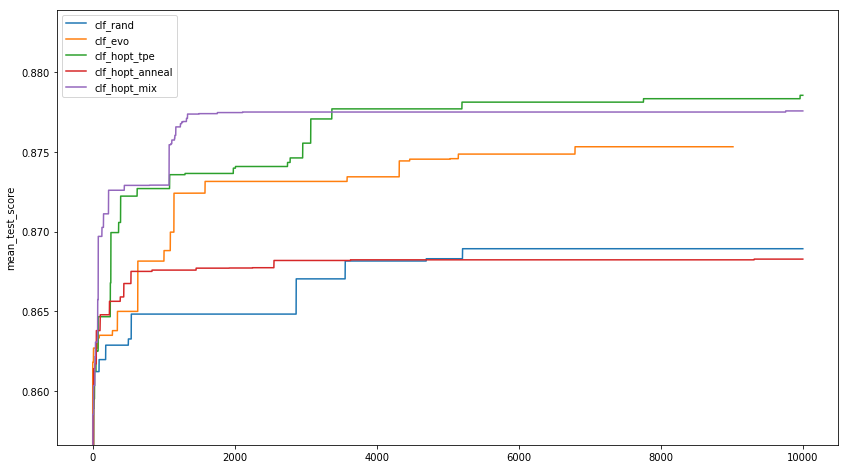

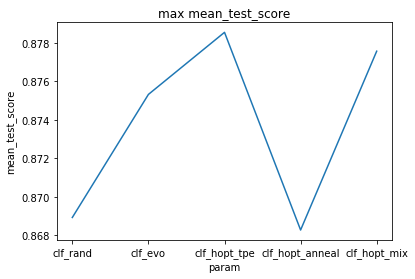

In [133]:
scip.cv_results_test_scores(clfs)

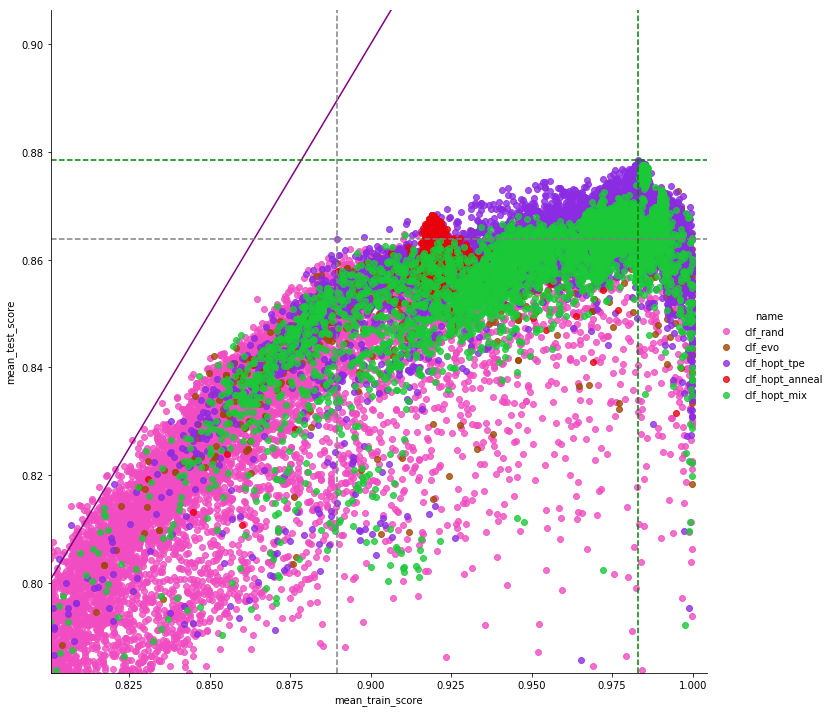

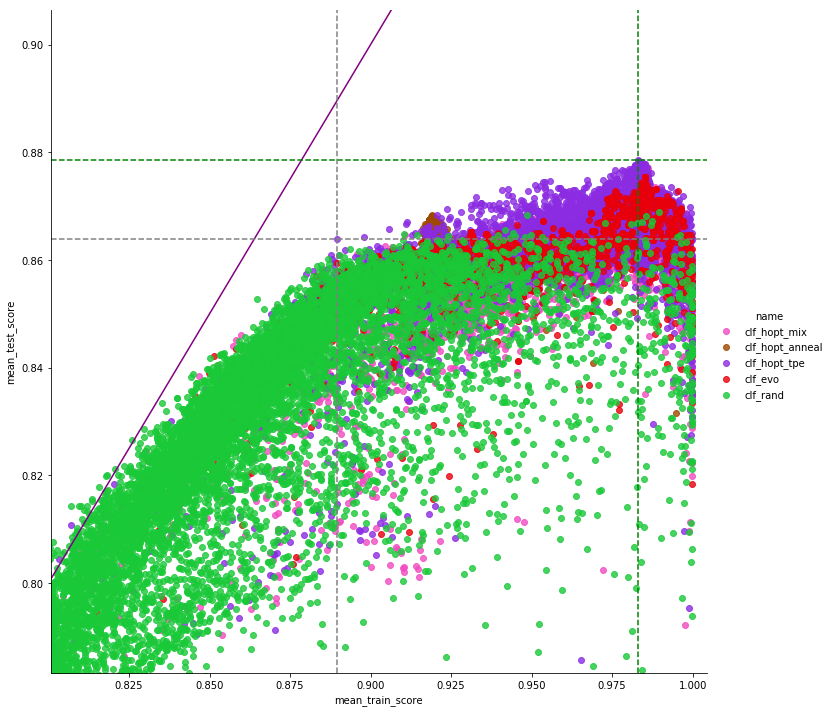

In [134]:
scip.cv_results_scatter_many(clfs)


In [54]:
# for name, (clf, fit_params) in clfs.items():
#     scip.cv_results_scatter(clf, hue=None)
#     plt.title(name)

In [135]:
df = pd.DataFrame(clf_hopt_mix.cv_results_)
params = df.params[np.argmax(df.mean_test_score)]
df[df.mean_test_score == df.mean_test_score.max()]
# df[df.loss == df.loss.min()]
# params

loss  loss_variance  mean_test_score  mean_train_score  \
9758 0.12243        0.03392          0.87757           0.98437   

                                                 params status  
9758  {'colsample_bylevel': 0.8907573353518072, 'col...     ok

In [136]:
model = model.set_params(**params)
# scil.score_cv(data, model, cv=3, scoring='accuracy')
np.mean(cross_val_score(model, X, y, scoring=clf_hopt_mix.scoring, cv=clf_hopt_mix.cv, n_jobs=1))
# cross_validate(model, X, y, scoring='accuracy', cv=3)

0.8775693220412095

In [87]:
res = []
for p in df.params.values:
    model.set_params(**p)
    res.append(np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=3)))

In [88]:
np.max(res), np.argmax(res)

(0.8574635241301908, 525)

fitting XGBClassifier ..
inverse_shuffle base_score: 0.5318 +/- 0.0071


is_woman_or_child   32.74531
Title               16.31753
is_woman            12.78942
Fare                12.23815
deck                 6.28445
Pclass               5.29217
family_size          3.74862
is_child             3.74862
Age                  3.63837
Fare_norm            2.75634
Embarked             2.64609
Parch                1.10254
SibSp               -0.22051
is_alone            -3.08710
dtype: float64

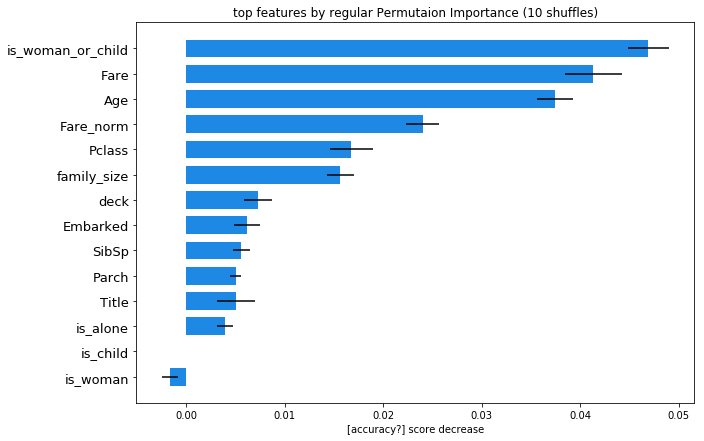

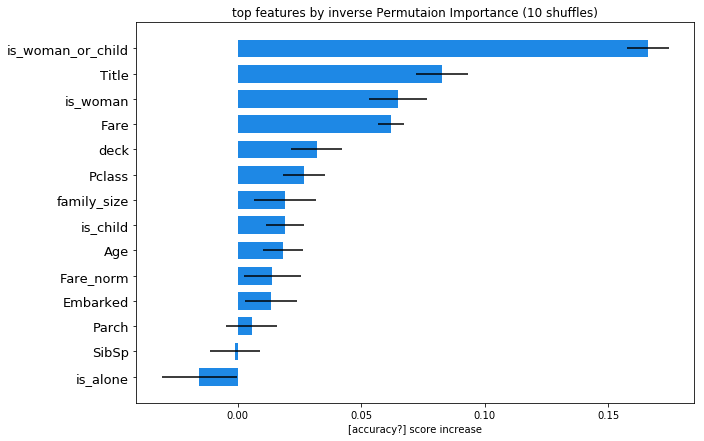

In [137]:
scil.fit(data, model, all_data=True)
scil.get_top_features_by_permutation_importance(data, model, False, 'accuracy', show=True)
scil.get_top_features_by_permutation_importance(data, model, True, 'accuracy', show=True)

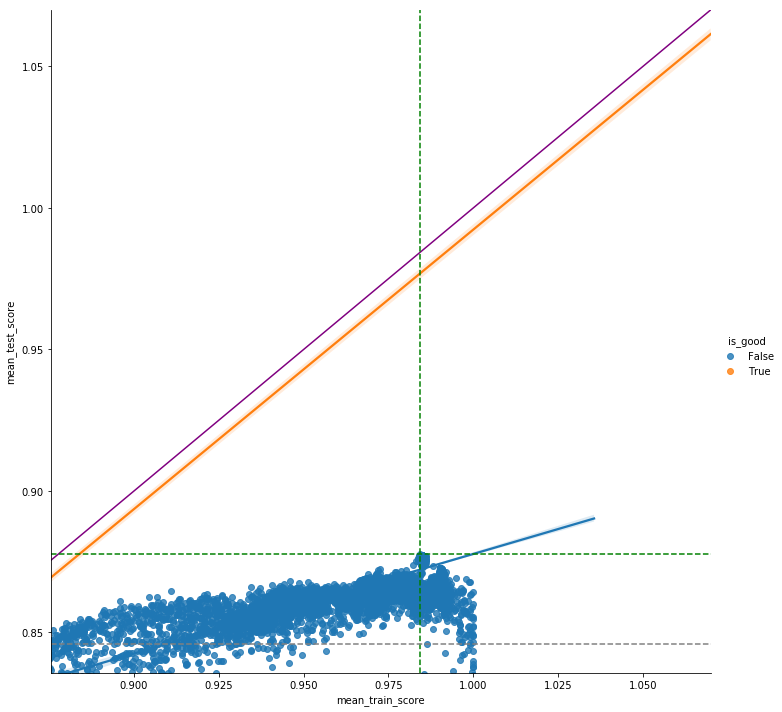

In [138]:
scip.cv_results_scatter(clf_hopt_mix)

## Random - submit 10 to Kaggle

In [212]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
# cv=2

clf_rand = RandomizedSearchCV(model, ss_rand, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=20000,
                         )
clf_rand.fit(X, y)


Fitting 15 folds for each of 20000 candidates, totalling 300000 fits


[Parallel(n_jobs=10)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1820 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done 4820 tasks      | elapsed:   20.6s
[Parallel(n_jobs=10)]: Done 9020 tasks      | elapsed:   39.5s
[Parallel(n_jobs=10)]: Done 14420 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 21020 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 28820 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 37820 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 48020 tasks      | elapsed:  3.6min
[Parallel(n_jobs=10)]: Done 59420 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 72020 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done 85820 tasks      | elapsed:  6.5min
[Parallel(n_jobs=10)]: Done 100820 tasks      | elapsed:  7.6min
[Parallel(n_jobs=10)]: Done 117020 tasks      | elapsed:  8.9min
[Parallel(n_jobs=10)]: Done 134420 tasks      | elapsed: 10.2min
[Parallel(n_jobs=10)]: Done 153020 tasks  

RandomizedSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a23454d68>,
          error_score=nan,
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=20000, n_jobs=10,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21bcab38>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1f517c18>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a232c8160>, 'subsample': <scipy.sta...32c8a58>, 'colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen object at 

[<matplotlib.lines.Line2D at 0x1a2334a780>]

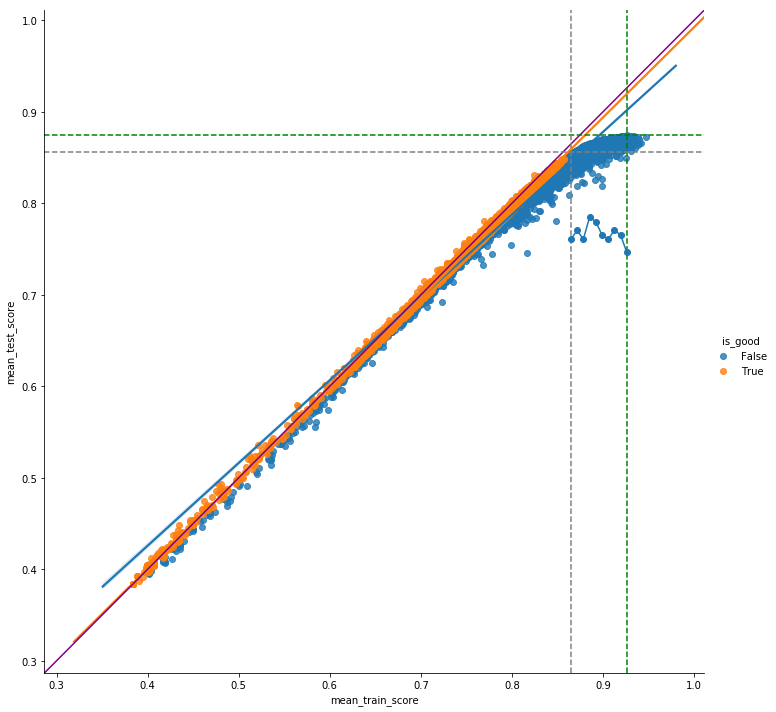

In [228]:
scip.cv_results_scatter(clf_rand, ratio_power=2)
# plt.xlim(0.8)
# plt.ylim(0.8)

# np.linspace(start, end, 10)
kaggle_x = [0.86476629, 0.87157133, 0.87837637, 0.88518141, 0.89198644, 0.89879148, 0.90559652, 0.91240156, 0.9192066 , 0.92601164]
kaggle_scores = [0.76076, 0.77033, 0.76076, 0.78468, 0.77990, 0.76555, 0.76076, 0.77033, 0.76555, 0.74641]
plt.plot(kaggle_x, kaggle_scores, marker='o')


[<matplotlib.lines.Line2D at 0x1a35a37358>]

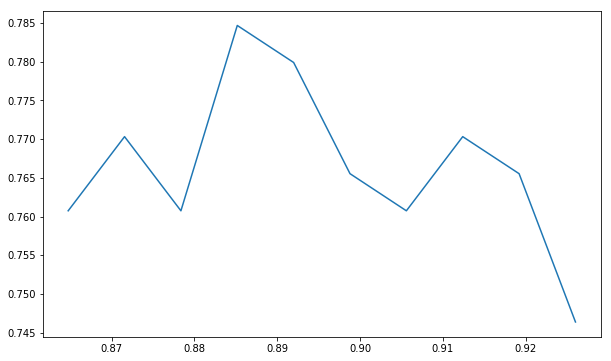

In [224]:
plt.plot(np.linspace(start, end, 10), kaggle_scores)

In [222]:
good_train_score, good_test_score, good_params_, good_idx = scit.get_good_model(clf_rand, ratio_power=2)
start = good_train_score

df = pd.DataFrame(clf_rand.cv_results_)
end = df.mean_train_score[np.argmax(df.mean_test_score)]

for i, x in enumerate(np.linspace(start, end, 10)):
    sdf = df[df.mean_train_score <= x]
    params = sdf.params[np.argmax(sdf.mean_test_score)]
    
    model.set_params(**params)
    model.fit(data.X, data.y)
    y_pred = model.predict(data.X_score).astype(int)
    
    # save submission using samples Ids
    index = pd.read_csv('input/gender_submission.csv')["PassengerId"]
    df_score = pd.DataFrame({"PassengerId": index, "Survived": y_pred})
    df_score.to_csv(f'input/submission_{i}.csv', index=False)    

## EvolutionaryAlgorithmSearchCV

### Optimal

In [325]:
# LB 0.77990
cv = RepeatedStratifiedKFold(5, 1)
clf_evo = EvolutionaryAlgorithmSearchCV(model, ss_evo, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=1, refit=refit,
                                   population_size=100,
                                   gene_mutation_prob=0.4,
                                   gene_crossover_prob=0.5,
                                   tournament_size=2,
                                   generations_number=5,
                                   return_train_score=True,
                                   iid=True,
                                   ratio_power=0)


In [326]:
clf_evo.fit(data.X, data.y)

Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	100   	0.806842	0.870183	0.834134 	0.999846 	0.806842   	0.870183   
1  	59    	0.837766	0.877277	0.874927 	0.999795 	0.837766   	0.877277   
2  	65    	0.850583	0.879255	0.896354 	0.999809 	0.850583   	0.879255   
3  	62    	0.860136	0.88093 	0.915509 	0.999854 	0.860136   	0.88093    
4  	48    	0.864575	0.886753	0.926622 	0.999849 	0.864575   	0.886753   
5  	58    	0.86665 	0.887784	0.93986  	0.999783 	0.86665    	0.887784   
Best individual is: {'n_estimators': 100, 'learning_rate': 0.0011233240329780276, 'max_depth': 20, 'subsample': 0.68, 'gamma': 3.1257158496882353, 'min_child_weight': 0, 'reg_lambda': 9.326033468832199e-05, 'reg_alpha': 2.848035868435805e-07, 'colsample_bytree': 0.65, 'colsample_bylevel': 0.9600000000000001}
with fitness: (0.8877

EvolutionaryAlgorithmSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a2a466d68>,
               error_score=nan,
               estimator=XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.7145092564637203,
       colsample_bytree=0.9050530154452167, gamma=0.5395267405150678,
       learning_rate=0.0022838909491760457, max_delta_step=0, max_depth=19,
       min_child_weight=0, missing=None, n_estimato...7329572e-06,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6694578396921266),
               fit_params={}, gene_crossover_prob=0.5,
               gene_mutation_prob=0.4,
               gene_type=[1, 2, 1, 2, 2, 1, 2, 2, 2, 2],
               generations_number=5, iid=True, n_jobs=10,
               params={'n_estimators': array([ 30,  31, ...,  99, 100]), 'learning_rate': array([1.00000e-04, 1.09750e-04, ..., 9.11163e-01, 1.00000e+00]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 1

In [251]:
# LB 0.77990 (ratio_power=0)
# LB 0.77511 (ratio_power=0.5)
# LB 0.78468 (ratio_power=2)
_, _, params, _ = scit.get_good_model(clf_evo, ratio_power=0.5)
model.set_params(**params)
model.fit(data.X, data.y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.72,
       colsample_bytree=0.51, gamma=2.5950242113997372e-08,
       learning_rate=0.0007054802310718645, max_delta_step=0, max_depth=19,
       min_child_weight=0, missing=None, n_estimators=64, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=8.111308307896873e-06, reg_lambda=2.656087782946684e-07,
       scale_pos_weight=1, seed=None, silent=True, subsample=0.72)

In [252]:
y_pred = model.predict(data.X_score)
y_pred = y_pred.astype(int)
# save submission using samples Ids
index = pd.read_csv('input/gender_submission.csv')["PassengerId"]
df_score = pd.DataFrame({"PassengerId": index, "Survived": y_pred})
df_score.to_csv('input/submission.csv', index=False)

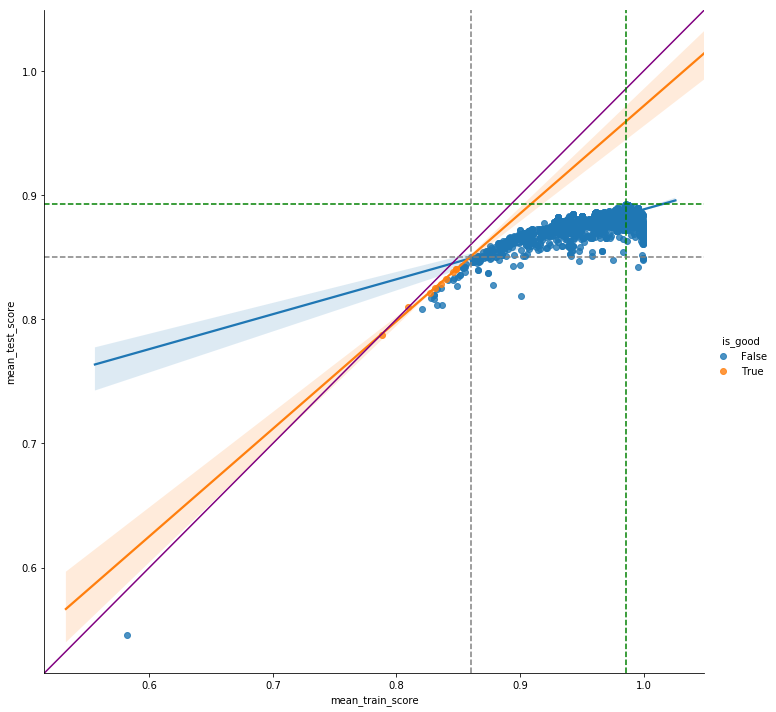

In [247]:
scip.cv_results_scatter(clf_evo, ratio_power=2)

XGBClassifier ..


test   train  test/train
XGBClassifier 0.84635 0.96481     0.87722

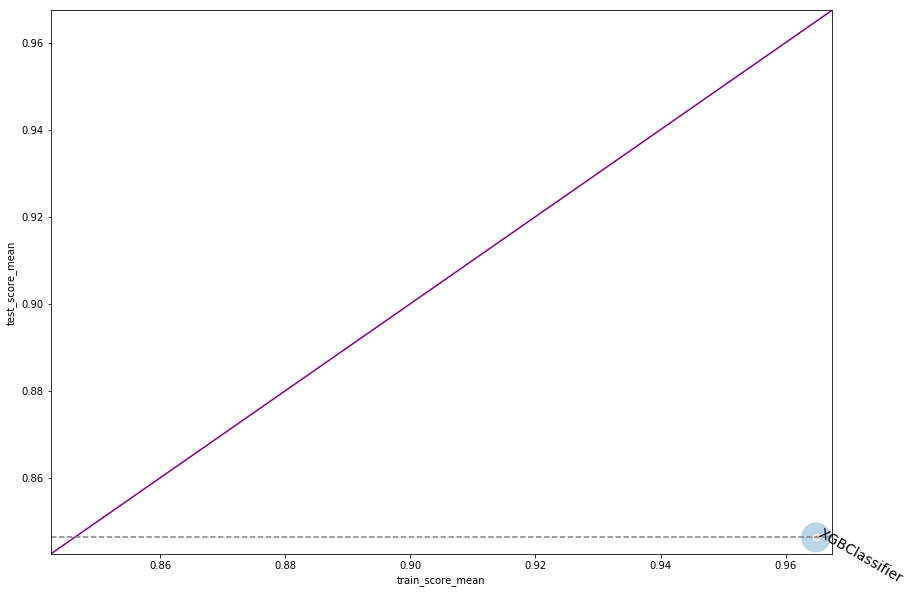

In [245]:
import sci.base as scib
scib.scoring_global = "accuracy"
scib.metric_global = accuracy_score
scip.models_train_test_scatter_cv(data, model, "predict", cv=5)

In [175]:
clf_evo = EvolutionaryAlgorithmSearchCV(model, ss_evo, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=1, refit=refit,
                                   # deap
                                   population_size=50,
                                   gene_mutation_prob=0.1,
                                   gene_crossover_prob=0.5,
                                   tournament_size=1,
                                   generations_number=100,
                                   return_train_score=True,
                                   iid=True,
                                   ratio_power=0
                                       )

clf_evo.fit(X, y);

Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	50    	0.777492	0.866453	0.795507 	0.999922 	0.777492   	0.866453   
1  	22    	0.795384	0.866453	0.81694  	0.999922 	0.795384   	0.866453   
2  	32    	0.786932	0.859227	0.797482 	0.930317 	0.786932   	0.859227   
3  	28    	0.784066	0.859227	0.791538 	0.948802 	0.784066   	0.859227   
4  	25    	0.772752	0.85511 	0.78213  	0.937334 	0.772752   	0.85511    
5  	18    	0.759764	0.85511 	0.768786 	0.937334 	0.759764   	0.85511    
6  	36    	0.779961	0.856605	0.787084 	0.885228 	0.779961   	0.856605   
7  	30    	0.75699 	0.862393	0.765134 	0.903593 	0.75699    	0.862393   
8  	36    	0.781982	0.866101	0.78732  	0.898378 	0.781982   	0.866101   
9  	27    	0.749915	0.861266	0.752711 	0.897054 	0.749915   	0.861266   
10 	33    	0.746635	0.852649	0.749581 	

In [180]:
clf_rand = RandomizedSearchCV(model, ss_rand, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=3000)
clf_rand.fit(X, y);


Fitting 2 folds for each of 3000 candidates, totalling 6000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 2580 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 6000 out of 6000 | elapsed:   15.2s finished


RandomizedSearchCV(cv=2, error_score=nan,
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=3000, n_jobs=10,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1c59c160>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1c59c048>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1c4778d0>, 'subsample': <scipy.sta...b903208>, 'colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2b903748>},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
        

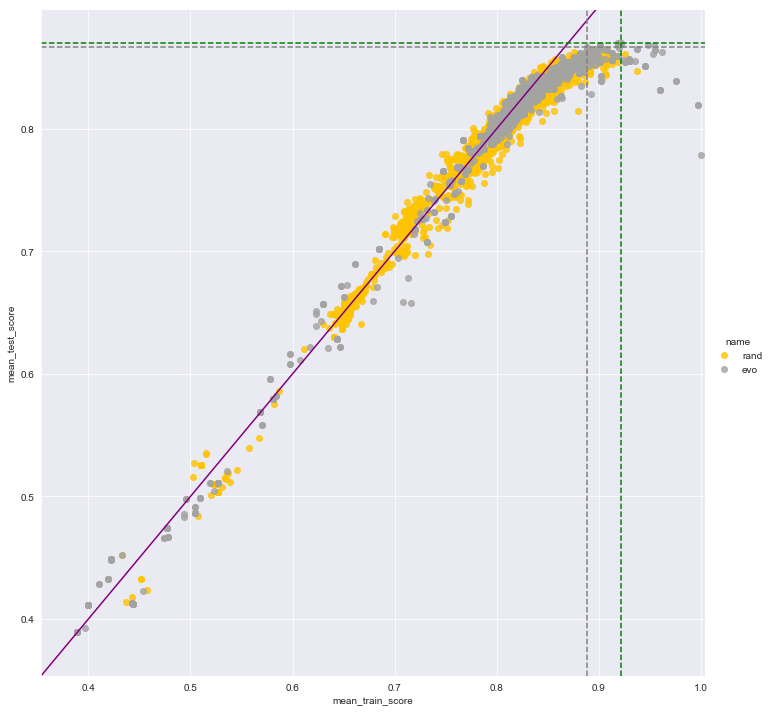

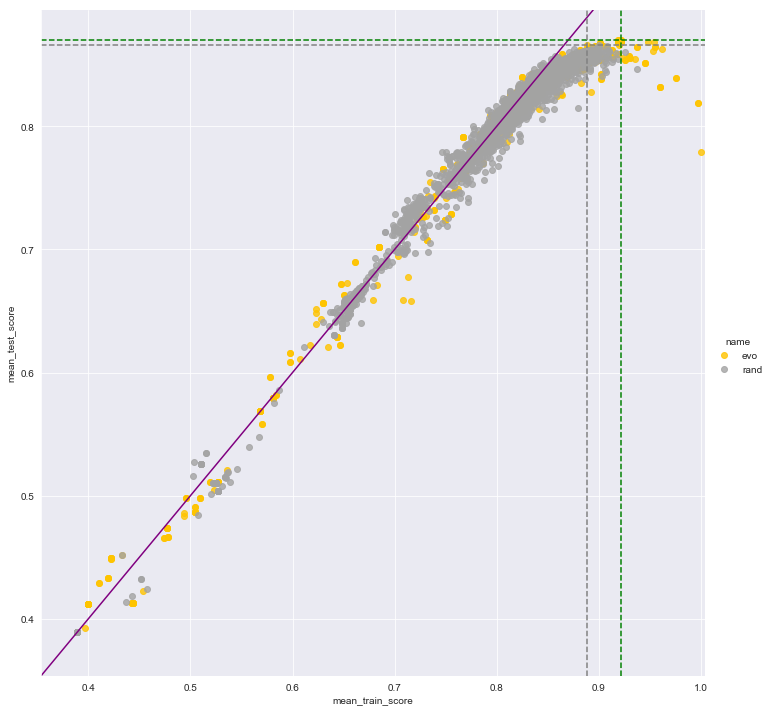

In [181]:
scip.cv_results_scatter_many([clf_rand, clf_evo], ["rand", "evo"])
scip.cv_results_scatter_many([clf_evo, clf_rand], ["evo", "rand"])

evo
0.8704585265216775
rand
0.8662101846944502


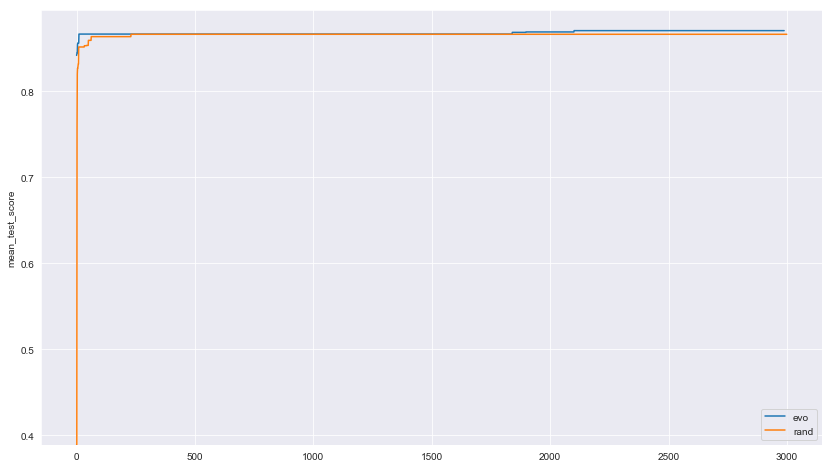

In [182]:
scip.cv_results_test_scores([clf_evo, clf_rand], ["evo", "rand"])

### EvolutionaryAlgorithmSearchCV - Random Search style

In [175]:
clf_evo = EvolutionaryAlgorithmSearchCV(model, ss_evo, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=1, refit=refit,
                                   # deap
                                   population_size=50,
                                   gene_mutation_prob=0.1,
                                   gene_crossover_prob=0.5,
                                   tournament_size=1,
                                   generations_number=100,
                                   return_train_score=True,
                                   iid=True,
                                   ratio_power=0
                                       )

clf_evo.fit(X, y);

Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	50    	0.777492	0.866453	0.795507 	0.999922 	0.777492   	0.866453   
1  	22    	0.795384	0.866453	0.81694  	0.999922 	0.795384   	0.866453   
2  	32    	0.786932	0.859227	0.797482 	0.930317 	0.786932   	0.859227   
3  	28    	0.784066	0.859227	0.791538 	0.948802 	0.784066   	0.859227   
4  	25    	0.772752	0.85511 	0.78213  	0.937334 	0.772752   	0.85511    
5  	18    	0.759764	0.85511 	0.768786 	0.937334 	0.759764   	0.85511    
6  	36    	0.779961	0.856605	0.787084 	0.885228 	0.779961   	0.856605   
7  	30    	0.75699 	0.862393	0.765134 	0.903593 	0.75699    	0.862393   
8  	36    	0.781982	0.866101	0.78732  	0.898378 	0.781982   	0.866101   
9  	27    	0.749915	0.861266	0.752711 	0.897054 	0.749915   	0.861266   
10 	33    	0.746635	0.852649	0.749581 	

In [180]:
clf_rand = RandomizedSearchCV(model, ss_rand, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=3000)
clf_rand.fit(X, y);


Fitting 2 folds for each of 3000 candidates, totalling 6000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 2580 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 6000 out of 6000 | elapsed:   15.2s finished


RandomizedSearchCV(cv=2, error_score=nan,
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=3000, n_jobs=10,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1c59c160>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1c59c048>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1c4778d0>, 'subsample': <scipy.sta...b903208>, 'colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2b903748>},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
        

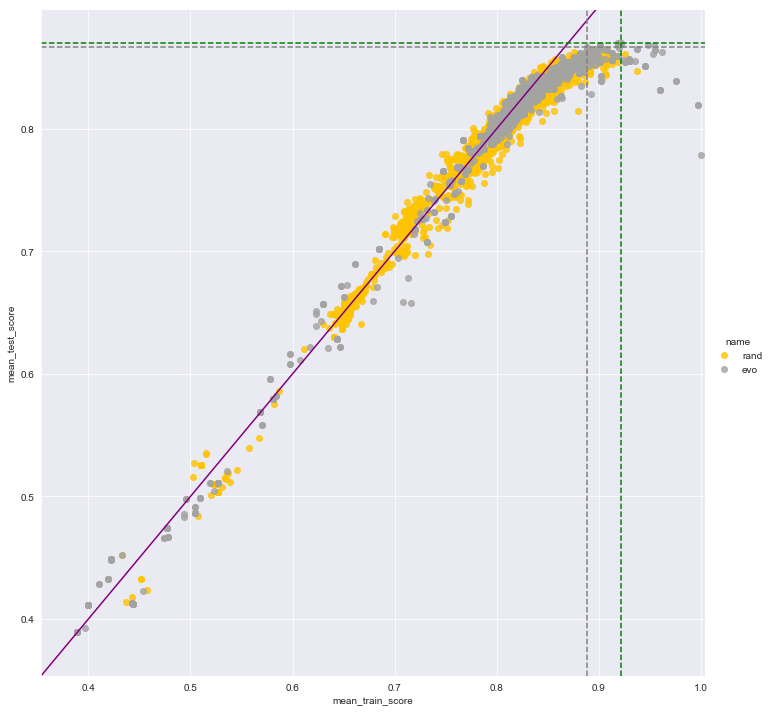

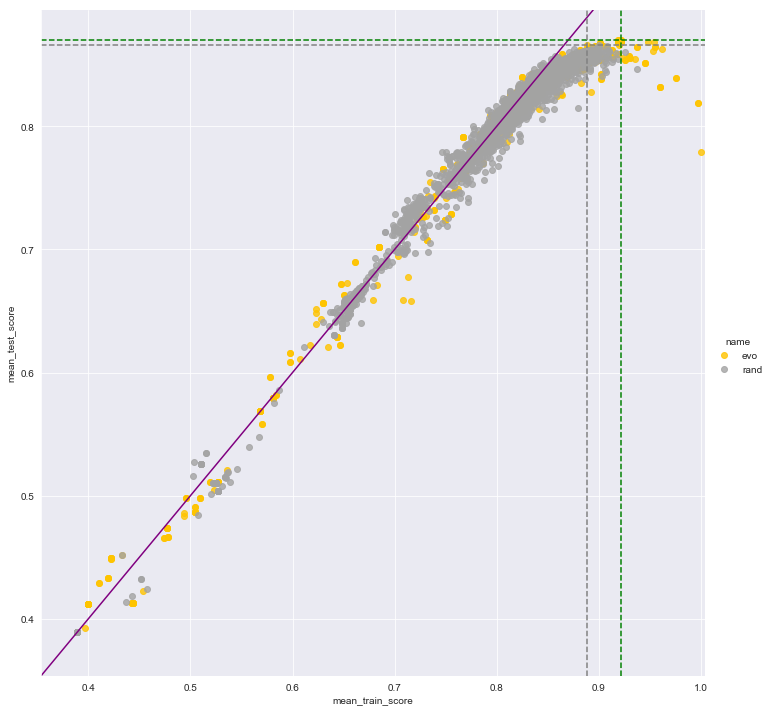

In [181]:
scip.cv_results_scatter_many([clf_rand, clf_evo], ["rand", "evo"])
scip.cv_results_scatter_many([clf_evo, clf_rand], ["evo", "rand"])

evo
0.8704585265216775
rand
0.8662101846944502


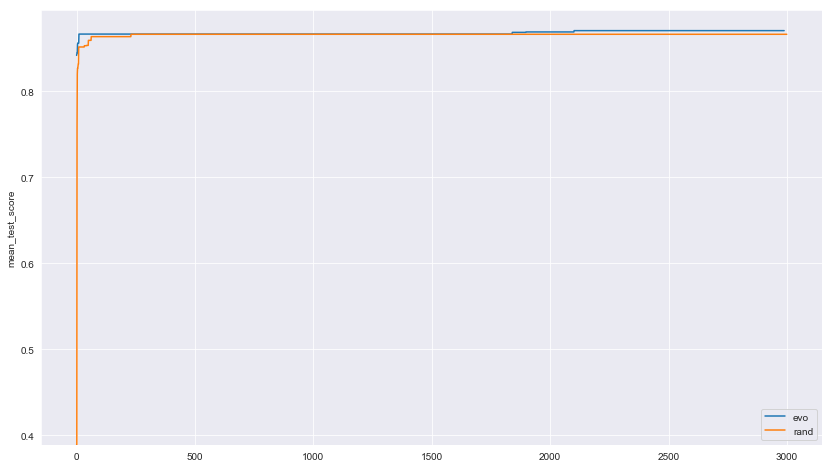

In [182]:
scip.cv_results_test_scores([clf_evo, clf_rand], ["evo", "rand"])

### Non-Random Search

In [183]:
clf_evo = EvolutionaryAlgorithmSearchCV(model, ss_evo, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=1, refit=refit,
                                   # deap
                                   population_size=50,
                                   gene_mutation_prob=0.1,
                                   gene_crossover_prob=0.5,
                                   tournament_size=2,
                                   generations_number=100,
                                   return_train_score=True,
                                   iid=True,
                                   ratio_power=0
                                       )

clf_evo.fit(X, y);

Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	50    	0.752025	0.867353	0.776717 	0.993404 	0.752025   	0.867353   
1  	34    	0.824533	0.870479	0.869615 	0.99971  	0.824533   	0.870479   
2  	28    	0.857033	0.870479	0.920089 	0.999712 	0.857033   	0.870479   
3  	28    	0.85906 	0.870479	0.931258 	0.999922 	0.85906    	0.870479   
4  	31    	0.862653	0.872124	0.93067  	0.995391 	0.862653   	0.872124   
5  	29    	0.863875	0.872586	0.928704 	0.991448 	0.863875   	0.872586   
6  	38    	0.856892	0.870302	0.915626 	0.95779  	0.856892   	0.870302   
7  	25    	0.866815	0.871224	0.931327 	0.991489 	0.866815   	0.871224   
8  	28    	0.867344	0.874065	0.927172 	0.95779  	0.867344   	0.874065   
9  	38    	0.86661 	0.872179	0.924943 	0.97497  	0.86661    	0.872179   
10 	31    	0.866815	0.872179	0.92279  	

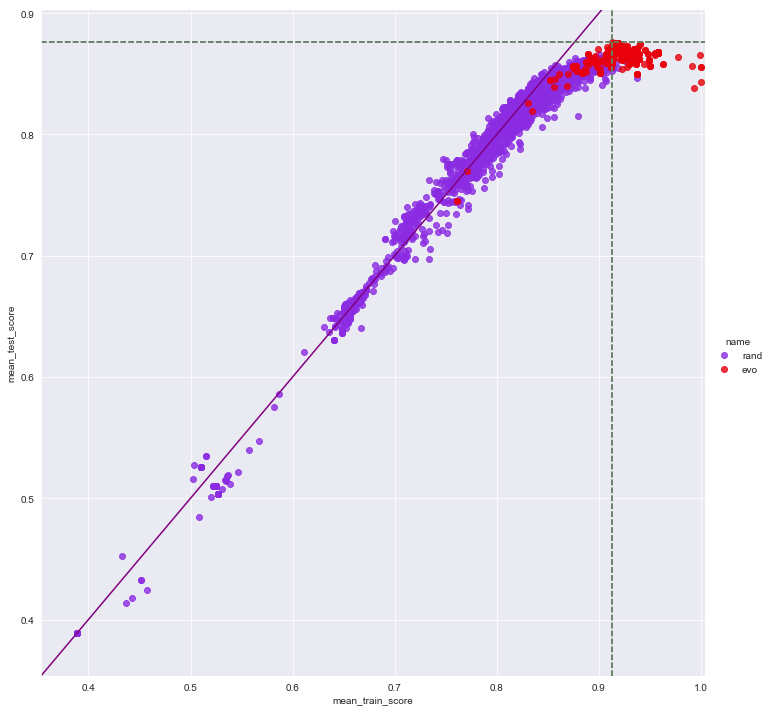

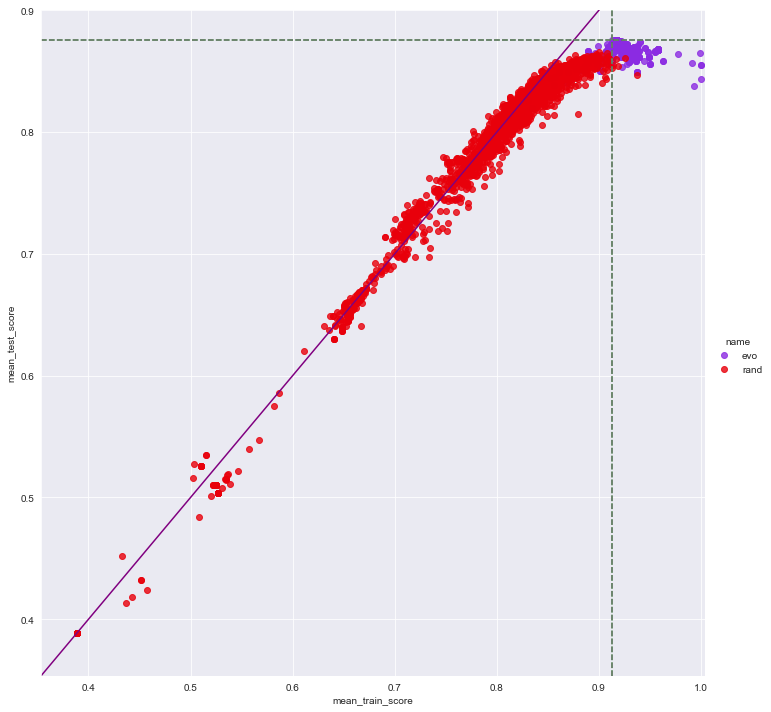

In [184]:
scip.cv_results_scatter_many([clf_rand, clf_evo], ["rand", "evo"])
scip.cv_results_scatter_many([clf_evo, clf_rand], ["evo", "rand"])

evo
0.8759500055766007
rand
0.8662101846944502


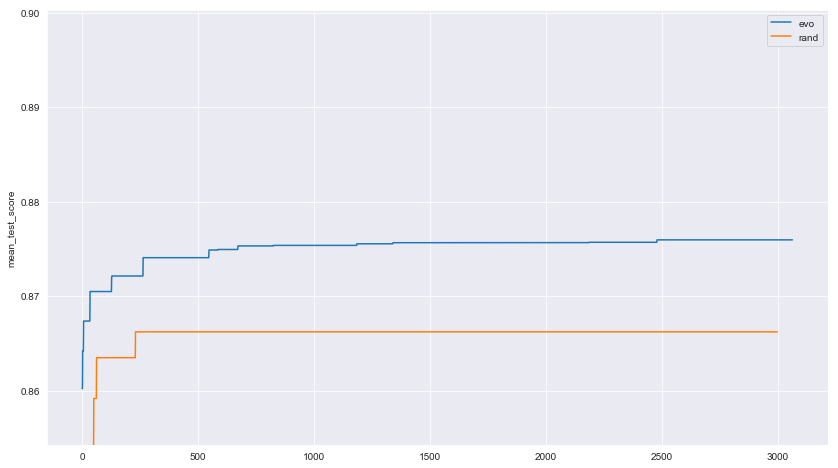

In [185]:
scip.cv_results_test_scores([clf_evo, clf_rand], ["evo", "rand"])

### population_size values

In [198]:
from sklearn.base import clone

population_size_res = []
for i in range(1, 10):
    clf_evo = EvolutionaryAlgorithmSearchCV(model, ss_evo, scoring=scoring, cv=2, n_jobs=n_jobs, error_score=error_score, verbose=1, refit=refit,
                                   # deap
                                   population_size=i*20,
                                   gene_mutation_prob=0.1,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=50,
                                   return_train_score=True,
                                   iid=True,
                                   ratio_power=0)


    clf_evo.fit(X, y)
    population_size_res.append(clf_evo)


Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	20    	0.770201	0.862126	0.804282 	0.999563 	0.770201   	0.862126   
1  	12    	0.845599	0.863725	0.877914 	0.92815  	0.845599   	0.863725   
2  	13    	0.855208	0.863725	0.892235 	0.945318 	0.855208   	0.863725   
3  	18    	0.858141	0.864486	0.902228 	0.96616  	0.858141   	0.864486   
4  	14    	0.860517	0.869432	0.899718 	0.938447 	0.860517   	0.869432   
5  	13    	0.862497	0.869432	0.900339 	0.934432 	0.862497   	0.869432   
6  	14    	0.864488	0.869432	0.90681  	0.958187 	0.864488   	0.869432   
7  	9     	0.866082	0.869432	0.905714 	0.910889 	0.866082   	0.869432   
8  	10    	0.867252	0.869432	0.90814  	0.910889 	0.867252   	0.869432   
9  	10    	0.86803 	0.86946 	0.907219 	0.910889 	0.86803    	0.86946    
10 	11    	0.868027	0.86946 	0.909652 	

Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	60    	0.797312	0.869202	0.823702 	0.983093 	0.797312   	0.869202   
1  	39    	0.849456	0.871428	0.898735 	0.999546 	0.849456   	0.871428   
2  	33    	0.850715	0.871428	0.916996 	0.999869 	0.850715   	0.871428   
3  	32    	0.86586 	0.877072	0.945585 	0.999548 	0.86586    	0.877072   
4  	46    	0.867924	0.879727	0.953603 	0.999082 	0.867924   	0.879727   
5  	38    	0.869117	0.879727	0.956889 	0.999662 	0.869117   	0.879727   
6  	42    	0.870272	0.879727	0.955406 	0.999473 	0.870272   	0.879727   
7  	33    	0.87322 	0.879727	0.960882 	0.998118 	0.87322    	0.879727   
8  	40    	0.874088	0.879727	0.958195 	0.984645 	0.874088   	0.879727   
9  	32    	0.875368	0.879727	0.96347  	0.999572 	0.875368   	0.879727   
10 	25    	0.876312	0.879727	0.964597 	

50 	52    	0.881255	0.88331 	0.967718 	0.990777 	0.881255   	0.88331    
Best individual is: {'n_estimators': 43, 'learning_rate': 0.013848863713938732, 'max_depth': 6, 'subsample': 0.5700000000000001, 'gamma': 0.002310129700083158, 'min_child_weight': 0, 'reg_lambda': 8.111308307896872e-07, 'reg_alpha': 0.0035111917342151347, 'colsample_bytree': 0.62, 'colsample_bylevel': 0.62}
with fitness: (0.8833097664140286, 0.96831942098176, 0.8833097664140286)
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	100   	0.784666	0.869861	0.807081 	0.99446  	0.784666   	0.869861   
1  	64    	0.84879 	0.869861	0.884622 	0.995532 	0.84879    	0.869861   
2  	58    	0.860005	0.874448	0.907255 	0.998912 	0.860005   	0.874448   
3  	54    	0.864575	0.874448	0.918633 	0.992506 	0.864575   	0.874448   
4  	65    	0.865517	0.

44 	78    	0.878687	0.881515	0.986199 	0.999922 	0.878687   	0.881515   
45 	80    	0.879704	0.881515	0.989877 	0.999678 	0.879704   	0.881515   
46 	70    	0.877996	0.881515	0.987537 	0.9995   	0.877996   	0.881515   
47 	77    	0.880506	0.881515	0.992712 	0.999763 	0.880506   	0.881515   
48 	69    	0.879891	0.881515	0.991184 	0.999922 	0.879891   	0.881515   
49 	84    	0.878611	0.881515	0.991835 	0.99921  	0.878611   	0.881515   
50 	68    	0.88019 	0.881542	0.991596 	0.998739 	0.88019    	0.881542   
Best individual is: {'n_estimators': 62, 'learning_rate': 0.0005857020818056667, 'max_depth': 13, 'subsample': 0.86, 'gamma': 1.0974987654930568e-05, 'min_child_weight': 0, 'reg_lambda': 4.037017258596558e-05, 'reg_alpha': 4.328761281083062e-05, 'colsample_bytree': 0.5700000000000001, 'colsample_bylevel': 0.46}
with fitness: (0.8815423519143746, 0.9946543239671174, 0.8815423519143746)
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
---

38 	89    	0.880102	0.881847	0.988515 	0.997891 	0.880102   	0.881847   
39 	91    	0.88022 	0.881847	0.989999 	0.999578 	0.88022    	0.881847   
40 	95    	0.880336	0.881847	0.989951 	0.999922 	0.880336   	0.881847   
41 	85    	0.878822	0.881847	0.990173 	0.999317 	0.878822   	0.881847   
42 	96    	0.879746	0.881847	0.989147 	0.999922 	0.879746   	0.881847   
43 	84    	0.879835	0.881847	0.990421 	0.999475 	0.879835   	0.881847   
44 	98    	0.879614	0.881847	0.990605 	0.999922 	0.879614   	0.881847   
45 	93    	0.880258	0.881847	0.990607 	0.999621 	0.880258   	0.881847   
46 	95    	0.880324	0.881847	0.99138  	0.999922 	0.880324   	0.881847   
47 	105   	0.877323	0.881847	0.9847   	0.999922 	0.877323   	0.881847   
48 	93    	0.880741	0.881847	0.99158  	0.999621 	0.880741   	0.881847   
49 	96    	0.879692	0.881847	0.990864 	0.999922 	0.879692   	0.881847   
50 	101   	0.876984	0.881847	0.985623 	0.999922 	0.876984   	0.881847   
Best individual is: {'n_estimators': 63, 'learning_

0
0.8729252122518748
1
0.8773920797333709
2
0.8807132861069278
3
0.8833097664140286
4
0.8766364082036749
5
0.8815150723214931
6
0.8806968948689334
7
0.8818467711451715
8
0.8832631497441172


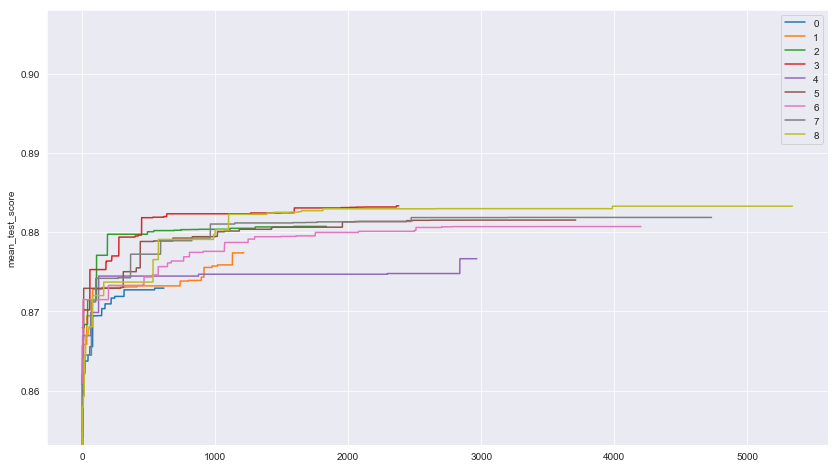

In [199]:
scip.cv_results_test_scores(population_size_res)

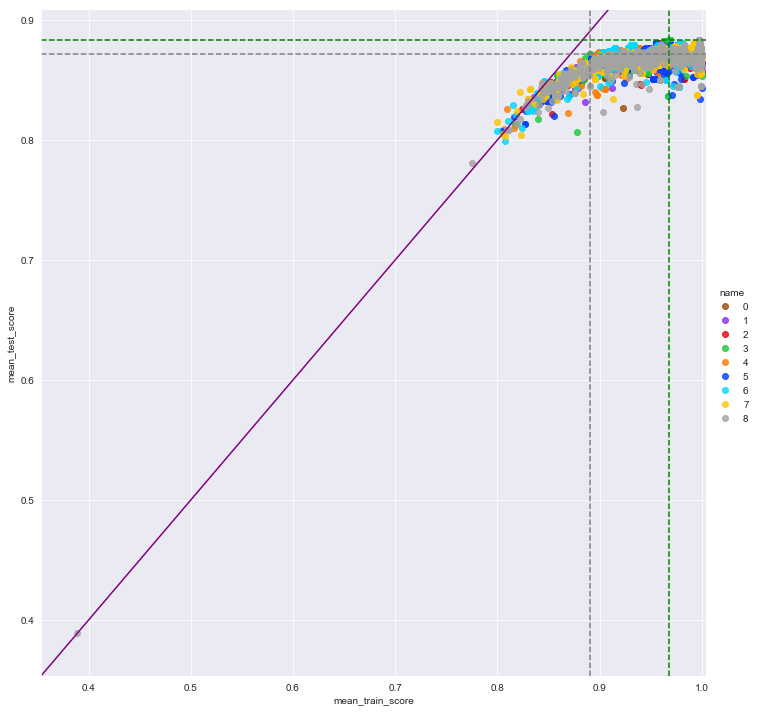

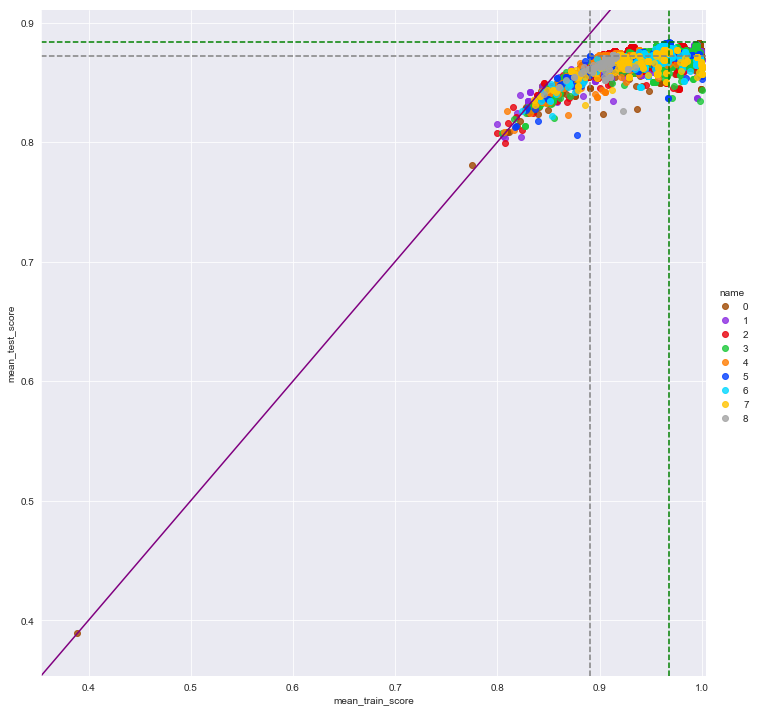

In [202]:
scip.cv_results_scatter_many(population_size_res)
scip.cv_results_scatter_many(population_size_res[::-1])

### multiple populations

In [192]:
from sklearn.base import clone

multi_pop_res = []
for i in np.linspace(0, 1, 11):
    clf_evo = EvolutionaryAlgorithmSearchCV(model, ss_evo, scoring=scoring, cv=2, n_jobs=n_jobs, error_score=error_score, verbose=1, refit=refit,
                                   # deap
                                   population_size=50,
                                   gene_mutation_prob=0.1,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=50,
                                   return_train_score=True,
                                   iid=True,
                                   ratio_power=0)


    clf_evo.fit(X, y)
    multi_pop_res.append(clf_evo)


Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	50    	0.798027	0.871319	0.822408 	0.975866 	0.798027   	0.871319   
1  	38    	0.851214	0.870494	0.898252 	0.999761 	0.851214   	0.870494   
2  	28    	0.85945 	0.870494	0.906962 	0.976184 	0.85945    	0.870494   
3  	28    	0.85773 	0.870663	0.908723 	0.998931 	0.85773    	0.870663   
4  	29    	0.862411	0.870663	0.918367 	0.992121 	0.862411   	0.870663   
5  	24    	0.86632 	0.871119	0.921741 	0.976744 	0.86632    	0.871119   
6  	19    	0.867304	0.873182	0.915293 	0.966911 	0.867304   	0.873182   
7  	34    	0.866042	0.87287 	0.912466 	0.952795 	0.866042   	0.87287    
8  	27    	0.863806	0.87287 	0.911959 	0.959886 	0.863806   	0.87287    
9  	30    	0.858386	0.87287 	0.91125  	0.96085  	0.858386   	0.87287    
10 	23    	0.866628	0.872905	0.923958 	

50 	35    	0.873768	0.876886	0.931046 	0.953816 	0.873768   	0.876886   
Best individual is: {'n_estimators': 70, 'learning_rate': 0.02915053062825179, 'max_depth': 9, 'subsample': 0.73, 'gamma': 0.0007220809018385456, 'min_child_weight': 1, 'reg_lambda': 1.6297508346206468, 'reg_alpha': 0.043287612810830614, 'colsample_bytree': 0.86, 'colsample_bylevel': 0.41000000000000003}
with fitness: (0.8768859836763282, 0.9348679450791906, 0.8768859836763282)
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	50    	0.797325	0.865724	0.820833 	0.949647 	0.797325   	0.865724   
1  	32    	0.838844	0.873742	0.87177  	0.970166 	0.838844   	0.873742   
2  	28    	0.859925	0.870074	0.909723 	0.998055 	0.859925   	0.870074   
3  	26    	0.863309	0.870186	0.916465 	0.997164 	0.863309   	0.870186   
4  	32    	0.86571 	0.8

44 	27    	0.874942	0.878247	0.936753 	0.941903 	0.874942   	0.878247   
45 	30    	0.873797	0.878247	0.933303 	0.941391 	0.873797   	0.878247   
46 	29    	0.874797	0.878247	0.937982 	0.99772  	0.874797   	0.878247   
47 	32    	0.877118	0.878247	0.941222 	0.997453 	0.877118   	0.878247   
48 	37    	0.875285	0.878247	0.937141 	0.995129 	0.875285   	0.878247   
49 	32    	0.870609	0.878247	0.937602 	0.999269 	0.870609   	0.878247   
50 	27    	0.876801	0.878247	0.944075 	0.998329 	0.876801   	0.878247   
Best individual is: {'n_estimators': 93, 'learning_rate': 0.011497569953977368, 'max_depth': 8, 'subsample': 0.62, 'gamma': 0.1917910261672485, 'min_child_weight': 0, 'reg_lambda': 3.5111917342151277e-07, 'reg_alpha': 5.336699231206313e-07, 'colsample_bytree': 0.68, 'colsample_bylevel': 0.11}
with fitness: (0.8782470874609262, 0.9413914092547636, 0.8782470874609262)
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 15620000

38 	26    	0.879702	0.879895	0.978871 	0.999369 	0.879702   	0.879895   
39 	26    	0.877148	0.879895	0.971446 	0.998278 	0.877148   	0.879895   
40 	26    	0.879067	0.879895	0.97533  	0.978453 	0.879067   	0.879895   
41 	29    	0.876781	0.879906	0.968959 	0.978453 	0.876781   	0.879906   
42 	40    	0.877505	0.879906	0.97371  	0.999476 	0.877505   	0.879906   
43 	33    	0.876838	0.879895	0.972442 	0.999922 	0.876838   	0.879895   
44 	30    	0.878365	0.879895	0.975861 	0.999476 	0.878365   	0.879895   
45 	30    	0.878593	0.879895	0.979574 	0.999922 	0.878593   	0.879895   
46 	24    	0.878268	0.879895	0.978323 	0.999922 	0.878268   	0.879895   
47 	29    	0.877002	0.879895	0.97241  	0.999163 	0.877002   	0.879895   
48 	31    	0.877998	0.879895	0.976706 	0.994565 	0.877998   	0.879895   
49 	33    	0.877664	0.879895	0.972166 	0.97915  	0.877664   	0.879895   
50 	24    	0.878693	0.879895	0.977547 	0.999163 	0.878693   	0.879895   
Best individual is: {'n_estimators': 84, 'learning_

32 	34    	0.878488	0.879146	0.995281 	0.998666 	0.878488   	0.879146   
33 	34    	0.877506	0.879262	0.989849 	0.995162 	0.877506   	0.879262   
34 	31    	0.87212 	0.879262	0.974446 	0.999091 	0.87212    	0.879262   
35 	30    	0.877201	0.879267	0.990012 	0.99979  	0.877201   	0.879267   
36 	29    	0.876412	0.879273	0.989832 	0.996809 	0.876412   	0.879273   
37 	33    	0.875597	0.879273	0.982585 	0.999091 	0.875597   	0.879273   
38 	28    	0.877458	0.879273	0.989856 	0.995759 	0.877458   	0.879273   
39 	29    	0.878138	0.879273	0.989002 	0.995495 	0.878138   	0.879273   
40 	29    	0.87786 	0.879273	0.990845 	0.998993 	0.87786    	0.879273   
41 	27    	0.878563	0.879273	0.99525  	0.99745  	0.878563   	0.879273   
42 	34    	0.877427	0.879273	0.991566 	0.996552 	0.877427   	0.879273   
43 	25    	0.878531	0.879324	0.992772 	0.996262 	0.878531   	0.879324   
44 	35    	0.877495	0.879324	0.992372 	0.998724 	0.877495   	0.879324   
45 	21    	0.873384	0.879324	0.986093 	0.999761 	0.

26 	31    	0.874699	0.876644	0.991117 	0.997801 	0.874699   	0.876644   
27 	27    	0.874991	0.876644	0.990965 	0.997349 	0.874991   	0.876644   
28 	33    	0.875728	0.876644	0.991412 	0.998632 	0.875728   	0.876644   
29 	27    	0.875945	0.876644	0.994185 	0.997827 	0.875945   	0.876644   
30 	29    	0.874724	0.876644	0.993159 	0.999922 	0.874724   	0.876644   
31 	34    	0.875948	0.876644	0.992176 	0.99661  	0.875948   	0.876644   
32 	25    	0.874961	0.876644	0.990726 	0.997801 	0.874961   	0.876644   
33 	29    	0.875318	0.876644	0.98901  	0.995916 	0.875318   	0.876644   
34 	33    	0.872964	0.876644	0.985505 	0.997801 	0.872964   	0.876644   
35 	39    	0.872515	0.876644	0.986554 	0.999816 	0.872515   	0.876644   
36 	32    	0.873789	0.876644	0.986504 	0.995831 	0.873789   	0.876644   
37 	30    	0.874699	0.876644	0.988994 	0.999735 	0.874699   	0.876644   
38 	33    	0.873125	0.876644	0.983428 	0.994744 	0.873125   	0.876644   
39 	23    	0.87439 	0.876644	0.98752  	0.994893 	0.

0
0.8749535559001272
1
0.8768859836763282
2
0.877469784314657
3
0.8782470874609262
4
0.8790366933242016
5
0.8800876194301026
6
0.8751825338887911
7
0.879324453009049
8
0.8786554986331159
9
0.8766443303185877
10
0.8743219138689118


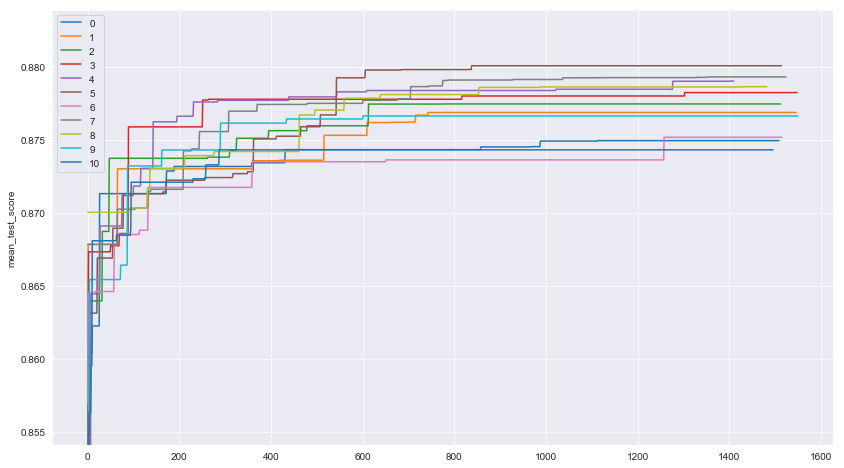

In [193]:
scip.cv_results_test_scores(multi_pop_res)

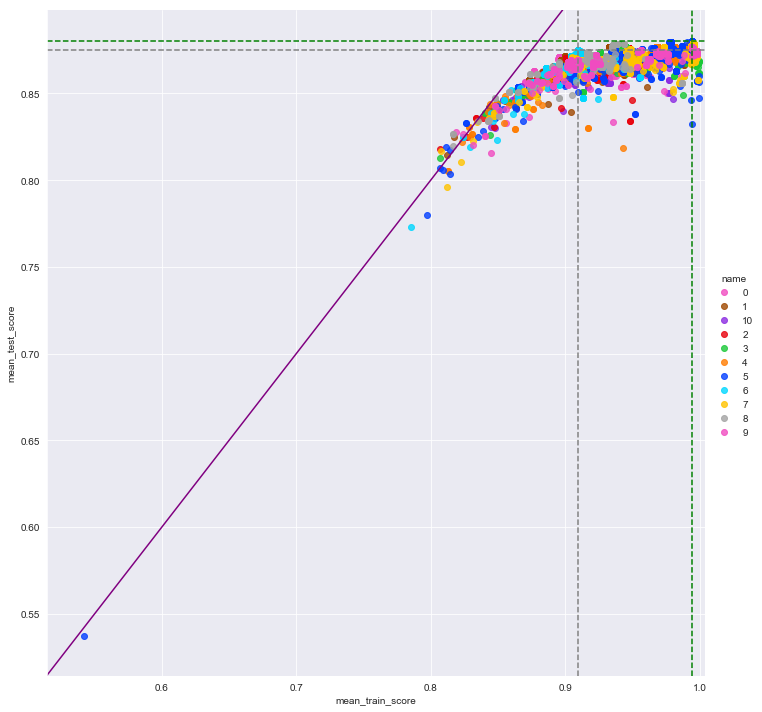

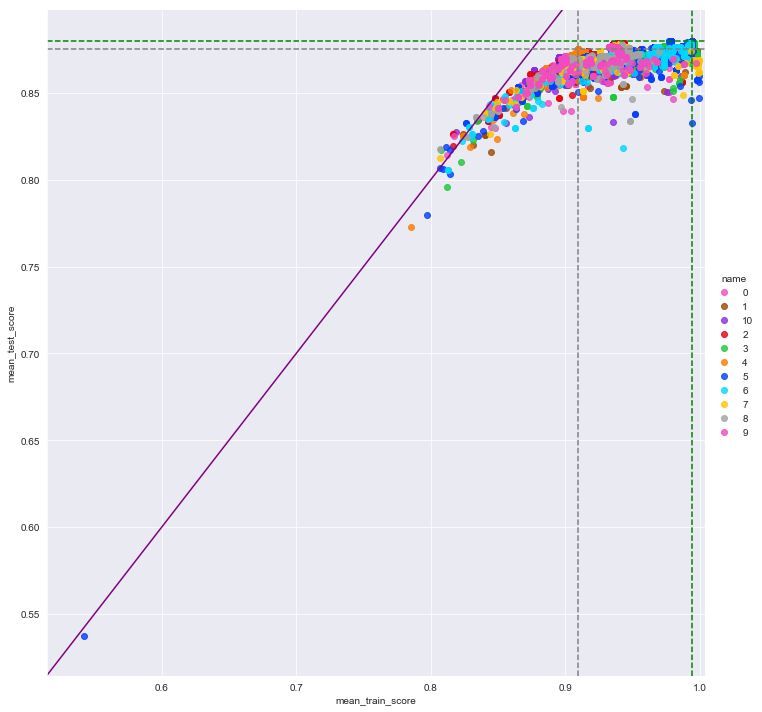

In [201]:
scip.cv_results_scatter_many(multi_pop_res)
scip.cv_results_scatter_many(multi_pop_res[::-1])

### ratio_power values

In [256]:
# LB 0.75119

from sklearn.base import clone
cv = RepeatedStratifiedKFold(5, 3)
ratio_power_res = []
for i in np.linspace(0, 2, 21):
    clf_evo = EvolutionaryAlgorithmSearchCV(model, ss_evo, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score, verbose=1, refit=refit,
                                   # deap
                                   population_size=100,
                                   gene_mutation_prob=0.4,
                                   gene_crossover_prob=0.5,
                                   tournament_size=2,
                                   generations_number=50,
                                   return_train_score=True,
                                   iid=True,
                                   ratio_power=i)


    clf_evo.fit(X, y)
    ratio_power_res.append(clf_evo)


Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	100   	0.808414	0.876905	0.841694 	0.999577 	0.808414   	0.876905   
1  	68    	0.851004	0.875305	0.890448 	0.999556 	0.851004   	0.875305   
2  	60    	0.8613  	0.876605	0.906109 	0.988879 	0.8613     	0.876605   
3  	67    	0.858353	0.87571 	0.903451 	0.994766 	0.858353   	0.87571    
4  	59    	0.863573	0.880514	0.913082 	0.994766 	0.863573   	0.880514   
5  	68    	0.867617	0.878729	0.928031 	0.999854 	0.867617   	0.878729   
6  	51    	0.863648	0.878247	0.924283 	0.999854 	0.863648   	0.878247   
7  	60    	0.863442	0.877287	0.92713  	0.999601 	0.863442   	0.877287   
8  	56    	0.867571	0.87807 	0.938988 	0.999461 	0.867571   	0.87807    
9  	51    	0.867787	0.878194	0.944722 	0.999793 	0.867787   	0.878194   
10 	58    	0.869232	0.878194	0.94794  	

50 	63    	0.876697	0.887693	0.950051 	0.999849 	0.869712   	0.878734   
Best individual is: {'n_estimators': 76, 'learning_rate': 0.002848035868435802, 'max_depth': 10, 'subsample': 0.97, 'gamma': 7.054802310718646e-05, 'min_child_weight': 0, 'reg_lambda': 0.008111308307896872, 'reg_alpha': 0.0002848035868435805, 'colsample_bytree': 0.51, 'colsample_bylevel': 0.68}
with fitness: (0.8814461250166264, 0.9899158370820468, 0.8907950976176867)
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	100   	0.802812	0.874822	0.832576 	0.998631 	0.797108   	0.861699   
1  	57    	0.848689	0.876644	0.884431 	0.998554 	0.841817   	0.867066   
2  	71    	0.852588	0.876568	0.889853 	0.998554 	0.845433   	0.864749   
3  	57    	0.853212	0.883509	0.898399 	0.999756 	0.84458    	0.866186   
4  	63    	0.864678	0.883873	0.91

44 	63    	0.864048	0.882116	0.898525 	0.976389 	0.854018   	0.864793   
45 	58    	0.862546	0.882116	0.897054 	0.998173 	0.852516   	0.864793   
46 	56    	0.864784	0.873916	0.899322 	0.945769 	0.854708   	0.862158   
47 	68    	0.864906	0.873123	0.901369 	0.988089 	0.854305   	0.861896   
48 	52    	0.860295	0.880975	0.896431 	0.987954 	0.849801   	0.862338   
49 	53    	0.861258	0.879521	0.898977 	0.999508 	0.850336   	0.861896   
50 	53    	0.863085	0.879521	0.897246 	0.975621 	0.853124   	0.861968   
Best individual is: {'n_estimators': 79, 'learning_rate': 0.0021544346900318843, 'max_depth': 7, 'subsample': 0.63, 'gamma': 0.029836472402833405, 'min_child_weight': 4, 'reg_lambda': 0.0026560877829466894, 'reg_alpha': 0.0003511191734215135, 'colsample_bytree': 0.66, 'colsample_bylevel': 0.72}
with fitness: (0.865722413120445, 0.9005664622370214, 0.8736417469242223)
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000

38 	64    	0.862421	0.873592	0.894475 	0.96598  	0.846883   	0.858747   
39 	61    	0.863168	0.873592	0.894592 	0.958999 	0.847925   	0.858747   
40 	60    	0.859578	0.873737	0.891073 	0.964992 	0.844326   	0.857271   
41 	65    	0.862102	0.872447	0.893174 	0.966202 	0.84702    	0.855894   
42 	68    	0.858678	0.874193	0.891864 	0.994445 	0.842635   	0.858017   
43 	65    	0.861028	0.872953	0.890892 	0.979399 	0.846537   	0.858454   
44 	69    	0.858731	0.873255	0.889038 	0.999595 	0.844102   	0.857725   
45 	60    	0.863123	0.874206	0.893239 	0.954026 	0.848487   	0.857445   
46 	71    	0.858989	0.882337	0.890582 	0.98797  	0.843724   	0.857445   
47 	57    	0.859189	0.872437	0.889862 	0.985403 	0.84434    	0.857445   
48 	56    	0.861969	0.874287	0.889156 	0.951978 	0.848715   	0.857445   
49 	53    	0.862361	0.874167	0.891317 	0.980603 	0.848292   	0.857445   
50 	62    	0.853787	0.871497	0.88223  	0.958601 	0.839953   	0.858272   
Best individual is: {'n_estimators': 88, 'learning_

32 	56    	0.857197	0.87449 	0.885173 	0.999848 	0.838266   	0.853294   
33 	48    	0.860467	0.869354	0.886176 	0.959625 	0.842963   	0.853926   
34 	66    	0.861092	0.876035	0.888557 	0.960508 	0.842457   	0.854974   
35 	64    	0.861095	0.872352	0.885634 	0.928532 	0.844345   	0.85538    
36 	59    	0.862199	0.87537 	0.887833 	0.935558 	0.844725   	0.855156   
37 	63    	0.863444	0.875587	0.890696 	0.932333 	0.844895   	0.855156   
38 	63    	0.851796	0.874955	0.877256 	0.940096 	0.834447   	0.855156   
39 	49    	0.851139	0.872481	0.878082 	0.966482 	0.832926   	0.855156   
40 	60    	0.858816	0.871336	0.884163 	0.942726 	0.841556   	0.855156   
41 	51    	0.858495	0.872942	0.884884 	0.975162 	0.840566   	0.855156   
42 	60    	0.854569	0.870288	0.880385 	0.985191 	0.837054   	0.854974   
43 	56    	0.857076	0.873051	0.883508 	0.959782 	0.839113   	0.854974   
44 	61    	0.855852	0.873622	0.884223 	0.976333 	0.836681   	0.854974   
45 	58    	0.863168	0.872794	0.888466 	0.907378 	0.

26 	46    	0.859699	0.871758	0.883879 	0.962054 	0.838575   	0.850155   
27 	64    	0.86271 	0.871758	0.886086 	0.920841 	0.84223    	0.850155   
28 	52    	0.858491	0.871758	0.882541 	0.994714 	0.837668   	0.852305   
29 	57    	0.859339	0.87354 	0.885059 	0.999806 	0.837114   	0.852305   
30 	64    	0.857401	0.871758	0.880782 	0.96284  	0.836997   	0.852892   
31 	46    	0.860541	0.871758	0.882792 	0.944392 	0.841058   	0.852305   
32 	61    	0.860981	0.871758	0.885047 	0.952515 	0.839995   	0.852305   
33 	70    	0.858159	0.870263	0.882001 	0.957196 	0.837371   	0.852305   
34 	56    	0.860275	0.869476	0.883104 	0.939435 	0.840296   	0.850155   
35 	53    	0.85887 	0.879281	0.880801 	0.997946 	0.839724   	0.850155   
36 	56    	0.854287	0.867833	0.877165 	0.99791  	0.834479   	0.854927   
37 	52    	0.855918	0.872269	0.880697 	0.984745 	0.834616   	0.852641   
38 	55    	0.856578	0.87976 	0.879389 	0.999852 	0.836812   	0.853609   
39 	60    	0.853951	0.871155	0.874701 	0.913279 	0.

20 	66    	0.849348	0.873941	0.869353 	0.941788 	0.827974   	0.852013   
21 	64    	0.851714	0.877017	0.87228  	0.994068 	0.829949   	0.852333   
22 	56    	0.851957	0.874789	0.870723 	0.959505 	0.831904   	0.852013   
23 	58    	0.854197	0.874567	0.874545 	0.970583 	0.832612   	0.850686   
24 	62    	0.858413	0.868113	0.876057 	0.901633 	0.839436   	0.850686   
25 	60    	0.857195	0.8677  	0.875082 	0.902608 	0.837974   	0.850686   
26 	64    	0.855987	0.873643	0.875581 	0.974514 	0.835121   	0.851666   
27 	49    	0.856783	0.881497	0.876371 	0.980326 	0.835878   	0.851666   
28 	51    	0.855454	0.879994	0.874637 	0.986488 	0.835087   	0.851666   
29 	61    	0.852329	0.872298	0.871623 	0.946863 	0.831759   	0.851666   
30 	72    	0.853029	0.875999	0.872157 	0.979749 	0.832638   	0.849649   
31 	47    	0.857116	0.875999	0.876909 	0.95613  	0.836002   	0.849649   
32 	63    	0.851579	0.868668	0.869106 	0.913766 	0.832755   	0.849649   
33 	68    	0.850909	0.871847	0.870247 	0.971401 	0.

14 	48    	0.854646	0.872203	0.876267 	0.921102 	0.827412   	0.839922   
15 	60    	0.851341	0.873455	0.87401  	0.99985  	0.822998   	0.843396   
16 	58    	0.850182	0.876002	0.872893 	0.946958 	0.82171    	0.842799   
17 	63    	0.853833	0.872211	0.877945 	0.998929 	0.823906   	0.847661   
18 	60    	0.852092	0.870401	0.871971 	0.923876 	0.82702    	0.846402   
19 	69    	0.858821	0.870191	0.87858  	0.938508 	0.833868   	0.846724   
20 	61    	0.858841	0.868161	0.87806  	0.904259 	0.834527   	0.846724   
21 	62    	0.857553	0.867636	0.87786  	0.923361 	0.831942   	0.847458   
22 	66    	0.860769	0.873911	0.881172 	0.918484 	0.835041   	0.847458   
23 	51    	0.855606	0.873911	0.876598 	0.958239 	0.829228   	0.847458   
24 	55    	0.859523	0.873169	0.880365 	0.95856  	0.833387   	0.848219   
25 	61    	0.859952	0.872266	0.882414 	0.96983  	0.831916   	0.847458   
26 	52    	0.859313	0.872819	0.881444 	0.957375 	0.831645   	0.847093   
27 	68    	0.844086	0.86957 	0.86278  	0.896502 	0.

8  	65    	0.840548	0.871322	0.859428 	0.967991 	0.813437   	0.836929   
9  	64    	0.852312	0.874057	0.872667 	0.930473 	0.822852   	0.836929   
10 	55    	0.847086	0.872448	0.865382 	0.926812 	0.820469   	0.84069    
11 	55    	0.847851	0.873174	0.870448 	0.959857 	0.815629   	0.84069    
12 	50    	0.848958	0.873734	0.867955 	0.916016 	0.821347   	0.84069    
13 	57    	0.853531	0.870526	0.873308 	0.937264 	0.824848   	0.846431   
14 	60    	0.844193	0.873774	0.863876 	0.957348 	0.815723   	0.846431   
15 	54    	0.849674	0.872099	0.86869  	0.965725 	0.822105   	0.846431   
16 	58    	0.855397	0.870707	0.874851 	0.910248 	0.827106   	0.846431   
17 	58    	0.8539  	0.867937	0.873024 	0.941652 	0.826112   	0.846431   
18 	57    	0.85457 	0.869974	0.875485 	0.996359 	0.824588   	0.843083   
19 	67    	0.853218	0.869146	0.873738 	0.984255 	0.823837   	0.843083   
20 	67    	0.855341	0.873667	0.875849 	0.967544 	0.825758   	0.847088   
21 	67    	0.856171	0.87303 	0.878015 	0.976882 	0.

2  	69    	0.835652	0.875271	0.8536   	0.970934 	0.806407   	0.834735   
3  	61    	0.836686	0.869909	0.854136 	0.938551 	0.80817    	0.835365   
4  	62    	0.840322	0.869627	0.85794  	0.913068 	0.811351   	0.835365   
5  	57    	0.842776	0.872322	0.861555 	0.956623 	0.812102   	0.835365   
6  	47    	0.84837 	0.871769	0.865715 	0.91353  	0.819784   	0.835365   
7  	64    	0.84857 	0.872686	0.867785 	0.949495 	0.81716    	0.835365   
8  	62    	0.850385	0.872554	0.869954 	0.953805 	0.818317   	0.835409   
9  	56    	0.845823	0.869852	0.865189 	0.921993 	0.814146   	0.835409   
10 	63    	0.846379	0.872157	0.866291 	0.97228  	0.813912   	0.835409   
11 	72    	0.849192	0.870308	0.86956  	0.994378 	0.816185   	0.83892    
12 	46    	0.850346	0.871411	0.870706 	0.937738 	0.817035   	0.83892    
13 	62    	0.844446	0.871856	0.86425  	0.969883 	0.8121     	0.83505    
14 	63    	0.852172	0.871856	0.873161 	0.999832 	0.818078   	0.83505    
15 	58    	0.853719	0.87017 	0.873968 	0.925252 	0.

--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	100   	0.804796	0.872836	0.830753 	0.999848 	0.75962    	0.83279    
1  	61    	0.830627	0.874535	0.852555 	0.97805  	0.791751   	0.83249    
2  	55    	0.833199	0.868137	0.851809 	0.99899  	0.800034   	0.83249    
3  	67    	0.843928	0.869358	0.864219 	0.961869 	0.807411   	0.829161   
4  	64    	0.844029	0.872603	0.862897 	0.99985  	0.810007   	0.830042   
5  	52    	0.847013	0.876569	0.865206 	0.938392 	0.813822   	0.827216   
6  	67    	0.843533	0.874625	0.863351 	0.961476 	0.80766    	0.83229    
7  	73    	0.84197 	0.875554	0.862276 	0.981813 	0.80526    	0.833653   
8  	60    	0.847792	0.872815	0.869148 	0.969958 	0.809253   	0.833653   
9  	59    	0.846606	0.871961	0.867932 	0.965494 	0.808284   	0.833653   
10 	49    	0.846574	0.874633	0.865248 	0.996755 	0.812821   	0.833653   
11 	65    	0.849732	0.874763	0.870643 	0.940493 	0.811873   	0.8

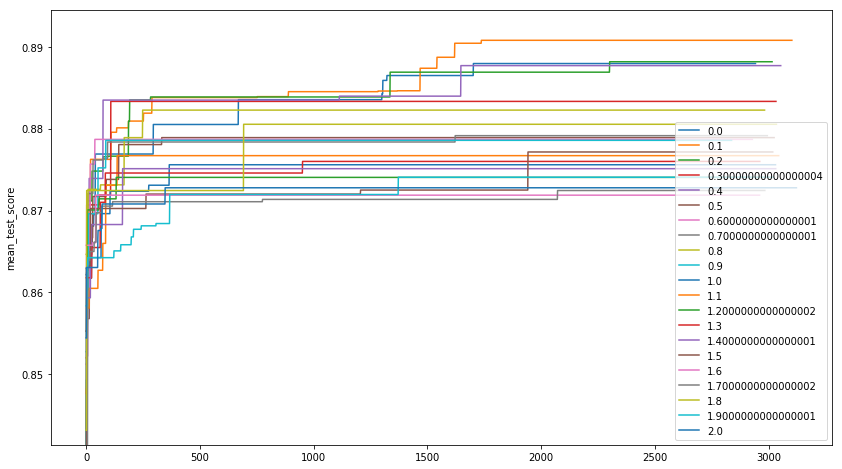

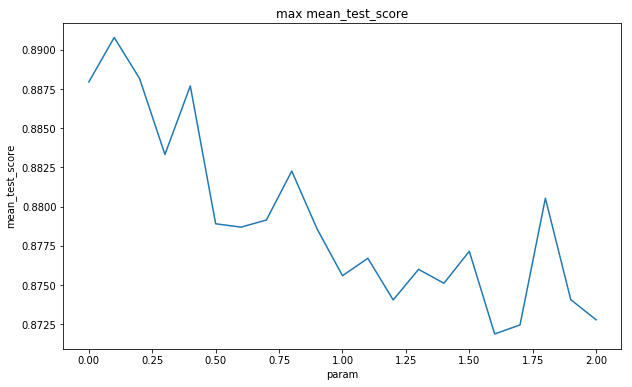

In [264]:
scip.cv_results_test_scores(ratio_power_res, xvalues=np.linspace(0, 2, 21))

In [274]:
# np.max(ratio_power_res[1].cv_results_['mean_test_score'])
model = ratio_power_res[1].best_estimator_

In [275]:
y_pred = model.predict(data.X_score)
y_pred = y_pred.astype(int)
# save submission using samples Ids
index = pd.read_csv('input/gender_submission.csv')["PassengerId"]
df_score = pd.DataFrame({"PassengerId": index, "Survived": y_pred})
df_score.to_csv('input/submission.csv', index=False)

(0.7, 0.9188602232869938)

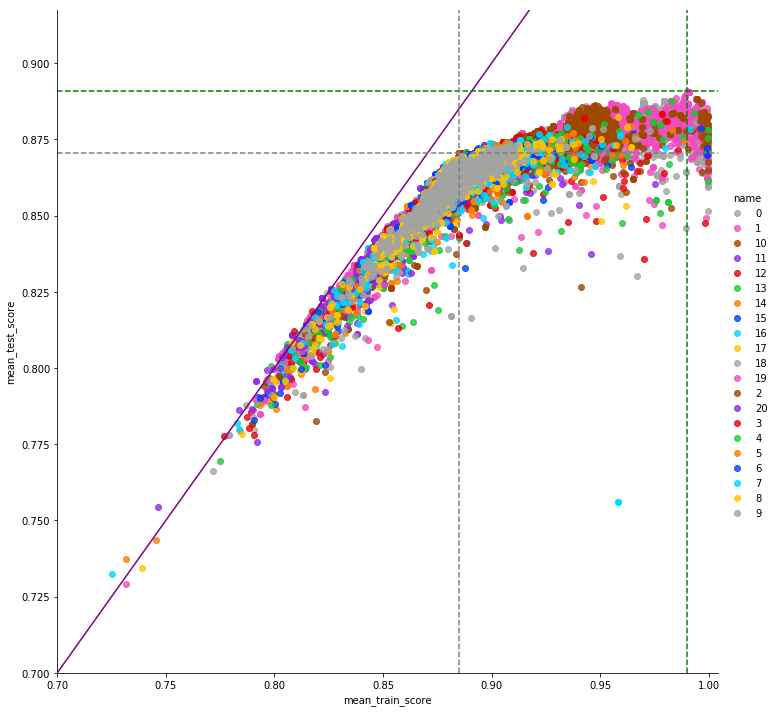

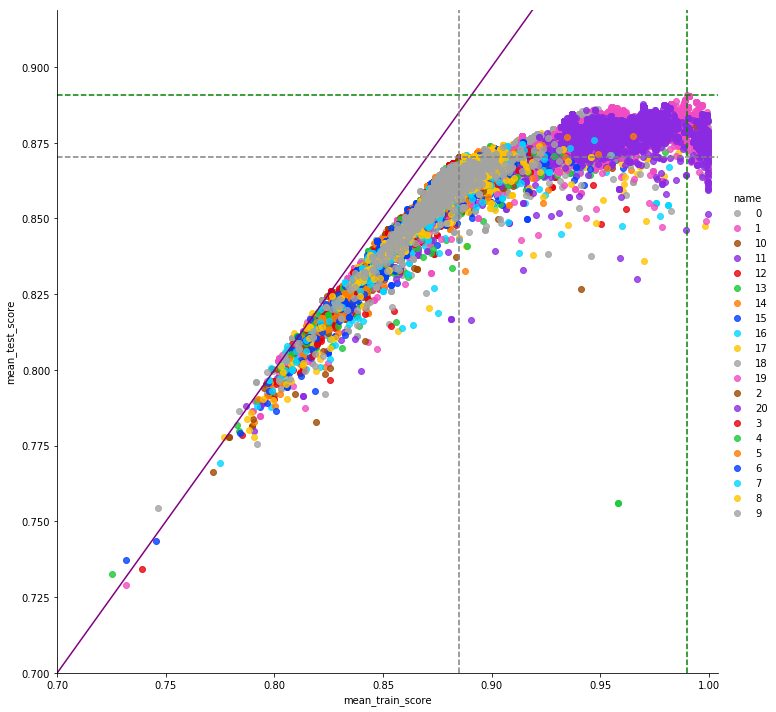

In [260]:
scip.cv_results_scatter_many(ratio_power_res)
plt.xlim(0.7)
plt.ylim(0.7)
scip.cv_results_scatter_many(ratio_power_res[::-1])
plt.xlim(0.7)
plt.ylim(0.7)


(0.7, 0.9)

<Figure size 864x576 with 0 Axes>

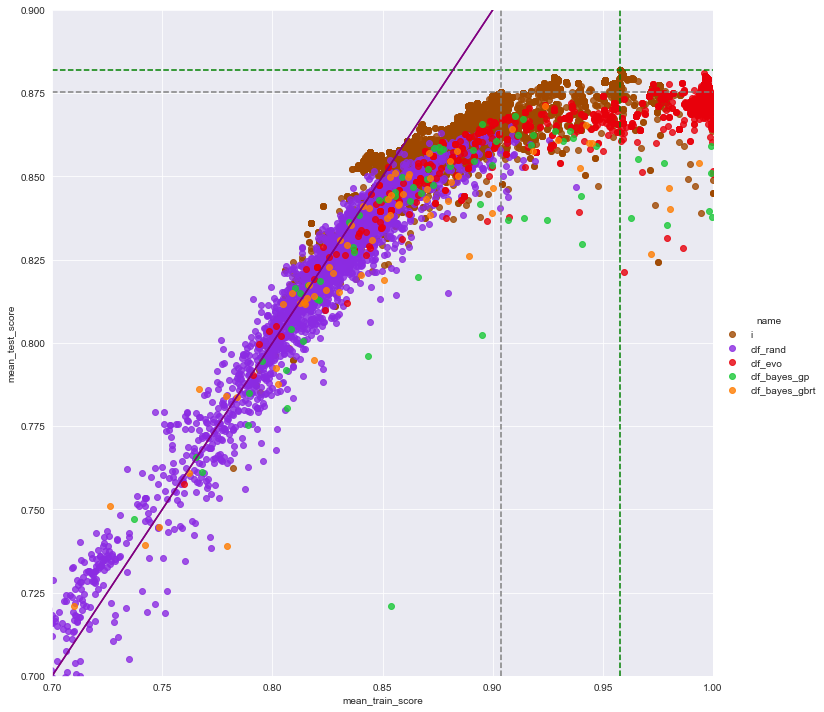

In [134]:
plt.figure(figsize=(12, 8))
tmp = {}
for i, clf in enumerate(res):
    tmp["i__" + str(i)] = (clf, {})

tmp['clf_rand'] = clfs['clf_rand']
tmp['clf_evo'] = clfs['clf_evo']
tmp['clf_bayes_gp'] = clfs['clf_bayes_gp']
tmp['clf_bayes_gbrt'] = clfs['clf_bayes_gbrt']


scatter_many_cv_results([c[0] for c in tmp.values()], list(x.split("__")[0] for x in tmp.keys()))
scip.diag_line()
plt.xlim(0.7, 1)
plt.ylim(0.7, 0.9)

### tournament_size values

In [195]:
from sklearn.base import clone

tournament_size_res = []
for i in range(1, 11):
    clf_evo = EvolutionaryAlgorithmSearchCV(model, ss_evo, scoring=scoring, cv=2, n_jobs=n_jobs, error_score=error_score, verbose=1, refit=refit,
                                   # deap
                                   population_size=50,
                                   gene_mutation_prob=0.1,
                                   gene_crossover_prob=0.5,
                                   tournament_size=i,
                                   generations_number=50,
                                   return_train_score=True,
                                   iid=True)


    clf_evo.fit(X, y)
    tournament_size_res.append(clf_evo)


Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	50    	0.781355	0.868079	0.804525 	0.97581  	0.781355   	0.868079   
1  	27    	0.777861	0.868332	0.801562 	0.998458 	0.777861   	0.868332   
2  	23    	0.801442	0.868332	0.820287 	0.998458 	0.801442   	0.868332   
3  	23    	0.816845	0.868332	0.839752 	0.99918  	0.816845   	0.868332   
4  	35    	0.824368	0.876853	0.850209 	0.999242 	0.824368   	0.876853   
5  	38    	0.818153	0.876853	0.857822 	0.999922 	0.818153   	0.876853   
6  	28    	0.830127	0.871814	0.875884 	0.999922 	0.830127   	0.871814   
7  	26    	0.841702	0.871163	0.892841 	0.999922 	0.841702   	0.871163   
8  	23    	0.853458	0.871163	0.917564 	0.999922 	0.853458   	0.871163   
9  	27    	0.845833	0.872197	0.894738 	0.999922 	0.845833   	0.872197   
10 	30    	0.851648	0.875655	0.905408 	

50 	28    	0.877377	0.878746	0.936648 	0.982779 	0.877377   	0.878746   
Best individual is: {'n_estimators': 34, 'learning_rate': 0.004534878508128582, 'max_depth': 20, 'subsample': 0.64, 'gamma': 8.302175681319736e-08, 'min_child_weight': 0, 'reg_lambda': 0.0006579332246575682, 'reg_alpha': 0.0001873817422860383, 'colsample_bytree': 0.48000000000000004, 'colsample_bylevel': 0.48000000000000004}
with fitness: (0.8806244875377429, 0.9699605042022298, 0.8806244875377429)
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	50    	0.762667	0.863276	0.786134 	0.984659 	0.762667   	0.863276   
1  	30    	0.82759 	0.867186	0.860939 	0.984659 	0.82759    	0.867186   
2  	34    	0.850226	0.869146	0.903966 	0.999111 	0.850226   	0.869146   
3  	38    	0.859031	0.875756	0.916012 	0.999449 	0.859031   	0.875756   
4 

45 	32    	0.875251	0.87896 	0.959702 	0.986423 	0.875251   	0.87896    
46 	29    	0.876336	0.87896 	0.964149 	0.99365  	0.876336   	0.87896    
47 	29    	0.873731	0.87896 	0.96261  	0.997554 	0.873731   	0.87896    
48 	39    	0.873588	0.87896 	0.960889 	0.997578 	0.873588   	0.87896    
49 	29    	0.87742 	0.879007	0.966429 	0.999401 	0.87742    	0.879007   
50 	29    	0.866172	0.879007	0.951748 	0.999765 	0.866172   	0.879007   
Best individual is: {'n_estimators': 31, 'learning_rate': 0.002364489412645407, 'max_depth': 10, 'subsample': 0.5800000000000001, 'gamma': 0.1519911082952933, 'min_child_weight': 0, 'reg_lambda': 1.3219411484660288e-09, 'reg_alpha': 1.873817422860387e-06, 'colsample_bytree': 0.68, 'colsample_bylevel': 0.32}
with fitness: (0.8790074502987282, 0.9663412482809755, 0.8790074502987282)
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	

39 	31    	0.874571	0.876602	0.942124 	0.992724 	0.874571   	0.876602   
40 	22    	0.875988	0.876602	0.943349 	0.987412 	0.875988   	0.876602   
41 	28    	0.87582 	0.876602	0.937015 	0.983491 	0.87582    	0.876602   
42 	25    	0.874893	0.876602	0.937962 	0.993359 	0.874893   	0.876602   
43 	43    	0.874571	0.877024	0.933061 	0.946377 	0.874571   	0.877024   
44 	27    	0.874918	0.877024	0.937707 	0.997216 	0.874918   	0.877024   
45 	33    	0.875689	0.877072	0.935321 	0.942655 	0.875689   	0.877072   
46 	28    	0.875845	0.877072	0.938968 	0.989741 	0.875845   	0.877072   
47 	31    	0.873442	0.877221	0.933811 	0.946817 	0.873442   	0.877221   
48 	31    	0.876661	0.877237	0.937765 	0.947947 	0.876661   	0.877237   
49 	28    	0.876343	0.877237	0.936968 	0.939037 	0.876343   	0.877237   
50 	26    	0.876929	0.877237	0.939778 	0.971721 	0.876929   	0.877237   
Best individual is: {'n_estimators': 91, 'learning_rate': 0.0013530477745798076, 'max_depth': 5, 'subsample': 0.8, 'gamma': 

33 	26    	0.870729	0.871553	0.928316 	0.957875 	0.870729   	0.871553   
34 	32    	0.870321	0.871553	0.927349 	0.952656 	0.870321   	0.871553   
35 	31    	0.870051	0.871553	0.927825 	0.963923 	0.870051   	0.871553   
36 	29    	0.859719	0.871553	0.915086 	0.977423 	0.859719   	0.871553   
37 	32    	0.869568	0.871553	0.924893 	0.950518 	0.869568   	0.871553   
38 	25    	0.870992	0.871553	0.928049 	0.92866  	0.870992   	0.871553   
39 	27    	0.87138 	0.871553	0.928915 	0.938916 	0.87138    	0.871553   
40 	33    	0.870973	0.871553	0.92918  	0.95508  	0.870973   	0.871553   
41 	26    	0.869354	0.871553	0.925944 	0.955494 	0.869354   	0.871553   
42 	24    	0.869966	0.871553	0.926854 	0.933212 	0.869966   	0.871553   
43 	35    	0.866601	0.871553	0.920545 	0.947086 	0.866601   	0.871553   
44 	35    	0.871299	0.871553	0.928258 	0.92866  	0.871299   	0.871553   
45 	22    	0.868611	0.871553	0.926106 	0.967876 	0.868611   	0.871553   
46 	28    	0.870059	0.871553	0.926641 	0.931145 	0.

27 	38    	0.876165	0.877479	0.989288 	0.999201 	0.876165   	0.877479   
28 	25    	0.874581	0.877479	0.985503 	0.999132 	0.874581   	0.877479   
29 	25    	0.875312	0.877479	0.984793 	0.994592 	0.875312   	0.877479   
30 	31    	0.876508	0.877479	0.988641 	0.99272  	0.876508   	0.877479   
31 	35    	0.870597	0.877479	0.981386 	0.995355 	0.870597   	0.877479   
32 	29    	0.877071	0.877479	0.989989 	0.995602 	0.877071   	0.877479   
33 	24    	0.875123	0.877479	0.987511 	0.999766 	0.875123   	0.877479   
34 	28    	0.875572	0.877479	0.986872 	0.995368 	0.875572   	0.877479   
35 	33    	0.874609	0.877479	0.985282 	0.991863 	0.874609   	0.877479   
36 	32    	0.8771  	0.877479	0.987687 	0.989806 	0.8771     	0.877479   
37 	35    	0.875586	0.877479	0.983989 	0.990793 	0.875586   	0.877479   
38 	27    	0.874915	0.877479	0.982989 	0.991635 	0.874915   	0.877479   
39 	34    	0.875341	0.877479	0.984983 	0.997686 	0.875341   	0.877479   
40 	27    	0.87435 	0.877479	0.985483 	0.989806 	0.

0
0.8768529927852656
1
0.8806244875377429
2
0.8807543521802217
3
0.8790074502987282
4
0.880697078887706
5
0.8772366580960558
6
0.8775498972083401
7
0.8715532563624884
8
0.8762865236455518
9
0.8774794917404621


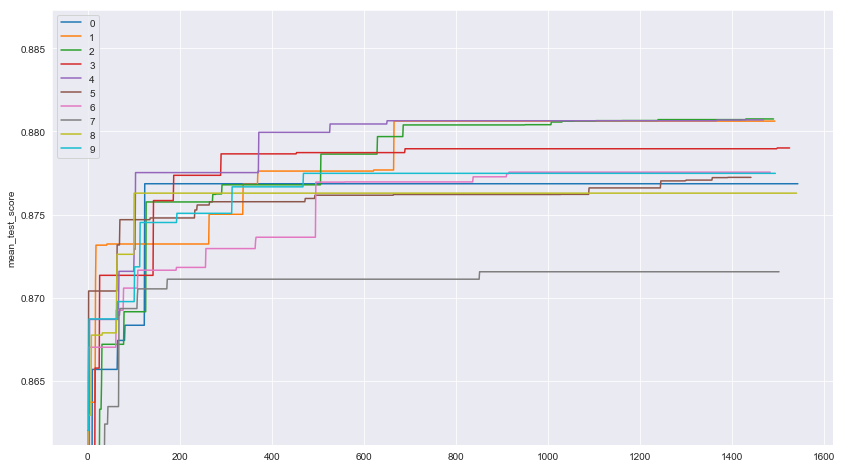

In [196]:
scip.cv_results_test_scores(tournament_size_res)

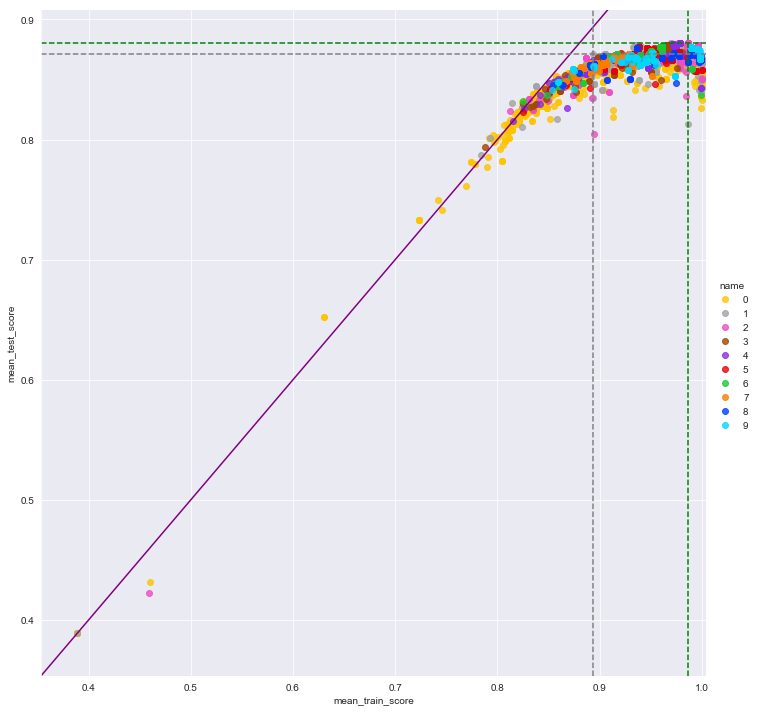

In [197]:
scip.cv_results_scatter_many(tournament_size_res)
scip.cv_results_scatter_many(tournament_size_res[::-1])

### gene_mutation_prob values

In [189]:
from sklearn.base import clone

gene_mutation_prob_names = np.linspace(0, 1, 11)
gene_mutation_prob_res = []
for i in np.linspace(0, 1, 11):
    clf_evo = EvolutionaryAlgorithmSearchCV(model, ss_evo, scoring=scoring, cv=2, n_jobs=n_jobs, error_score=error_score, verbose=1, refit=refit,
                                   # deap
                                   population_size=50,
                                   gene_mutation_prob=i,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=50,
                                   return_train_score=True,
                                   iid=True,
                                   ratio_power=0)


    clf_evo.fit(X, y)
    gene_mutation_prob_res.append(clf_evo)


Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	50    	0.798158	0.870183	0.827213 	0.993805 	0.798158   	0.870183   
1  	30    	0.85038 	0.870183	0.88359  	0.998116 	0.85038    	0.870183   
2  	35    	0.862394	0.87128 	0.919665 	0.998231 	0.862394   	0.87128    
3  	25    	0.867083	0.87128 	0.941125 	0.997649 	0.867083   	0.87128    
4  	37    	0.866786	0.87128 	0.948471 	0.999922 	0.866786   	0.87128    
5  	29    	0.867787	0.874375	0.9495   	0.999737 	0.867787   	0.874375   
6  	30    	0.868459	0.874375	0.953793 	0.999761 	0.868459   	0.874375   
7  	28    	0.869918	0.874375	0.949685 	0.999844 	0.869918   	0.874375   
8  	37    	0.870872	0.875079	0.955608 	0.992682 	0.870872   	0.875079   
9  	30    	0.872622	0.875079	0.950554 	0.992682 	0.872622   	0.875079   
10 	24    	0.873746	0.875079	0.950728 	

50 	29    	0.869806	0.870709	0.954183 	0.955991 	0.869806   	0.870709   
Best individual is: {'n_estimators': 74, 'learning_rate': 0.026560877829466867, 'max_depth': 19, 'subsample': 0.46, 'gamma': 1.747528400007683e-05, 'min_child_weight': 1, 'reg_lambda': 0.1747528400007683, 'reg_alpha': 1.232846739442066e-08, 'colsample_bytree': 0.8200000000000001, 'colsample_bylevel': 0.67}
with fitness: (0.8707089302076864, 0.9557717693071769, 0.8707089302076864)
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolve in 1562000000000000000 possible combinations ---
gen	nevals	test avg	test max	train avg	train max	fitness avg	fitness max
0  	50    	0.770633	0.86844 	0.796333 	0.999922 	0.770633   	0.86844    
1  	24    	0.847791	0.86844 	0.884853 	0.999922 	0.847791   	0.86844    
2  	24    	0.860188	0.870825	0.912356 	0.987595 	0.860188   	0.870825   
3  	23    	0.864219	0.870825	0.928463 	0.999226 	0.864219   	0.870825   
4  	38    	0.862562	0

44 	34    	0.873866	0.877558	0.979672 	0.997723 	0.873866   	0.877558   
45 	32    	0.875701	0.877558	0.990675 	0.999708 	0.875701   	0.877558   
46 	27    	0.869977	0.877558	0.974283 	0.996755 	0.869977   	0.877558   
47 	30    	0.86397 	0.877558	0.970284 	0.999761 	0.86397    	0.877558   
48 	36    	0.871377	0.877558	0.975804 	0.99694  	0.871377   	0.877558   
49 	31    	0.874732	0.877558	0.984387 	0.994734 	0.874732   	0.877558   
50 	31    	0.870314	0.877558	0.978609 	0.999922 	0.870314   	0.877558   
Best individual is: {'n_estimators': 42, 'learning_rate': 0.009545484566618348, 'max_depth': 11, 'subsample': 0.73, 'gamma': 0.005857020818056662, 'min_child_weight': 0, 'reg_lambda': 7.054802310718646e-05, 'reg_alpha': 0.043287612810830614, 'colsample_bytree': 0.55, 'colsample_bylevel': 0.7100000000000001}
with fitness: (0.8775583655913912, 0.99317918433503, 0.8775583655913912)
Types [1, 2, 1, 2, 2, 1, 2, 2, 2, 2] and maxint [70, 99, 19, 99, 99, 10, 99, 99, 99, 99] detected
--- Evolv

38 	31    	0.874668	0.88096 	0.93963  	0.956987 	0.874668   	0.88096    
39 	27    	0.860899	0.88096 	0.931028 	0.999619 	0.860899   	0.88096    
40 	27    	0.86433 	0.88096 	0.93046  	0.97861  	0.86433    	0.88096    
41 	28    	0.86535 	0.88096 	0.935429 	0.999922 	0.86535    	0.88096    
42 	34    	0.869882	0.88096 	0.944396 	0.993148 	0.869882   	0.88096    
43 	15    	0.867388	0.88096 	0.936404 	0.997502 	0.867388   	0.88096    
44 	28    	0.864765	0.88096 	0.934108 	0.999922 	0.864765   	0.88096    
45 	25    	0.872189	0.88096 	0.944337 	0.980692 	0.872189   	0.88096    
46 	31    	0.862406	0.88096 	0.927903 	0.996399 	0.862406   	0.88096    
47 	25    	0.872472	0.88096 	0.939143 	0.999714 	0.872472   	0.88096    
48 	32    	0.872427	0.88096 	0.939341 	0.999512 	0.872427   	0.88096    
49 	29    	0.864634	0.88096 	0.930908 	0.961188 	0.864634   	0.88096    
50 	34    	0.854732	0.88096 	0.916872 	0.958452 	0.854732   	0.88096    
Best individual is: {'n_estimators': 77, 'learning_

32 	29    	0.873306	0.881525	0.928186 	0.999922 	0.873306   	0.881525   
33 	28    	0.875702	0.881525	0.927344 	0.998871 	0.875702   	0.881525   
34 	28    	0.862705	0.881525	0.916528 	0.999318 	0.862705   	0.881525   
35 	30    	0.877586	0.881525	0.929158 	0.966581 	0.877586   	0.881525   
36 	35    	0.865266	0.881525	0.917476 	0.960991 	0.865266   	0.881525   
37 	34    	0.876785	0.881525	0.928592 	0.93665  	0.876785   	0.881525   
38 	29    	0.873955	0.881525	0.92761  	0.96481  	0.873955   	0.881525   
39 	36    	0.868809	0.881525	0.917839 	0.999869 	0.868809   	0.881525   
40 	28    	0.857157	0.881525	0.910924 	0.991549 	0.857157   	0.881525   
41 	34    	0.878326	0.881525	0.931548 	0.965541 	0.878326   	0.881525   
42 	29    	0.866321	0.881525	0.918018 	0.986922 	0.866321   	0.881525   
43 	42    	0.863973	0.881525	0.909067 	0.998768 	0.863973   	0.881525   
44 	22    	0.859433	0.881525	0.913585 	0.999922 	0.859433   	0.881525   
45 	27    	0.863326	0.881525	0.909199 	0.945672 	0.

26 	30    	0.845668	0.875732	0.90746  	0.999843 	0.845668   	0.875732   
27 	21    	0.869714	0.875732	0.936822 	0.999922 	0.869714   	0.875732   
28 	29    	0.871076	0.875732	0.937302 	0.950104 	0.871076   	0.875732   
29 	23    	0.870846	0.875732	0.941646 	0.987429 	0.870846   	0.875732   
30 	24    	0.857583	0.875732	0.92014  	0.950104 	0.857583   	0.875732   
31 	30    	0.859426	0.875732	0.927335 	0.998706 	0.859426   	0.875732   
32 	33    	0.86784 	0.875732	0.937886 	0.950104 	0.86784    	0.875732   
33 	27    	0.859141	0.875732	0.92779  	0.981989 	0.859141   	0.875732   
34 	33    	0.857376	0.875732	0.920719 	0.999922 	0.857376   	0.875732   
35 	27    	0.830905	0.875732	0.889054 	0.964393 	0.830905   	0.875732   
36 	40    	0.856015	0.876706	0.919625 	0.950405 	0.856015   	0.876706   
37 	23    	0.853334	0.876706	0.913777 	0.966399 	0.853334   	0.876706   
38 	24    	0.867036	0.876359	0.935292 	0.999922 	0.867036   	0.876359   
39 	23    	0.87075 	0.876359	0.942884 	0.992347 	0.

0
0.8750791463048958
1
0.8707089302076864
2
0.8783906509360923
3
0.8775583655913912
4
0.8806493524778035
5
0.8809599638378125
6
0.8788413752621219
7
0.8815246050614077
8
0.8776679609614907
9
0.8778857811445143
10
0.8794024655853693


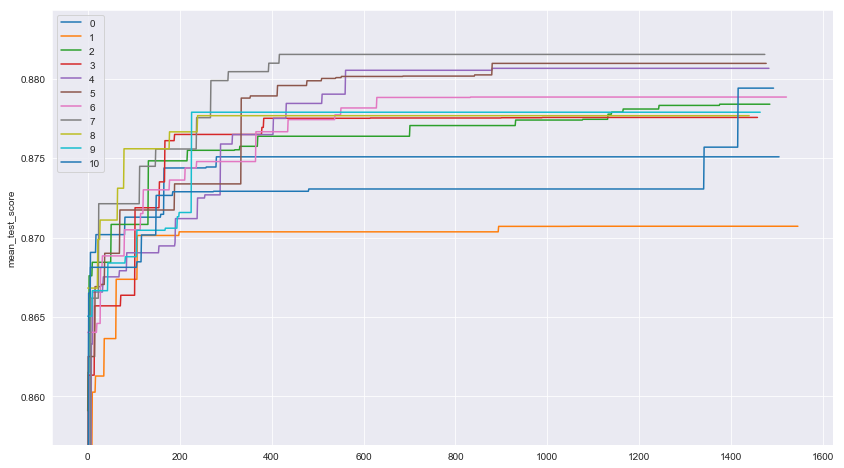

In [190]:
scip.cv_results_test_scores(gene_mutation_prob_res)

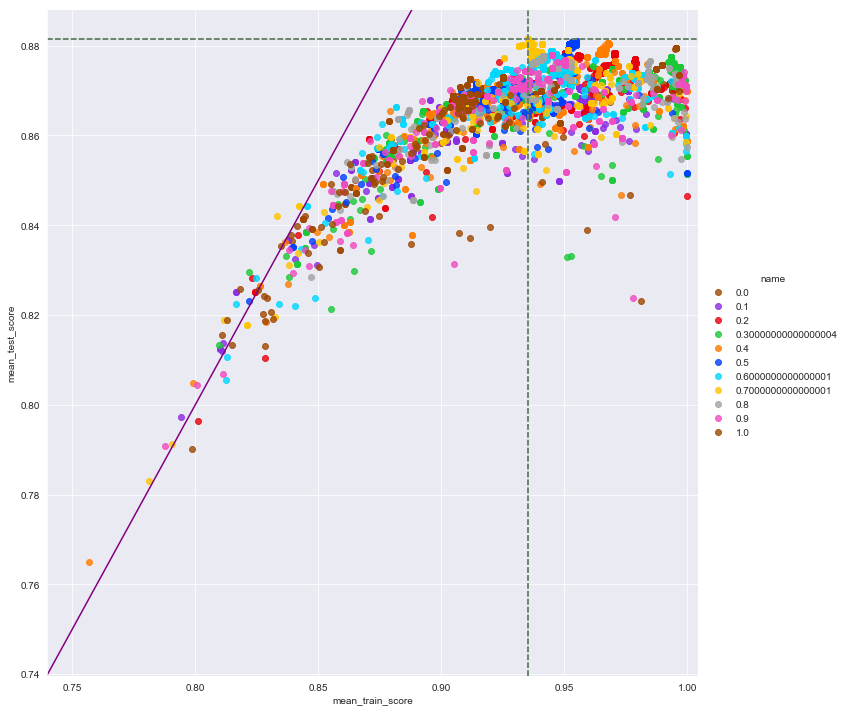

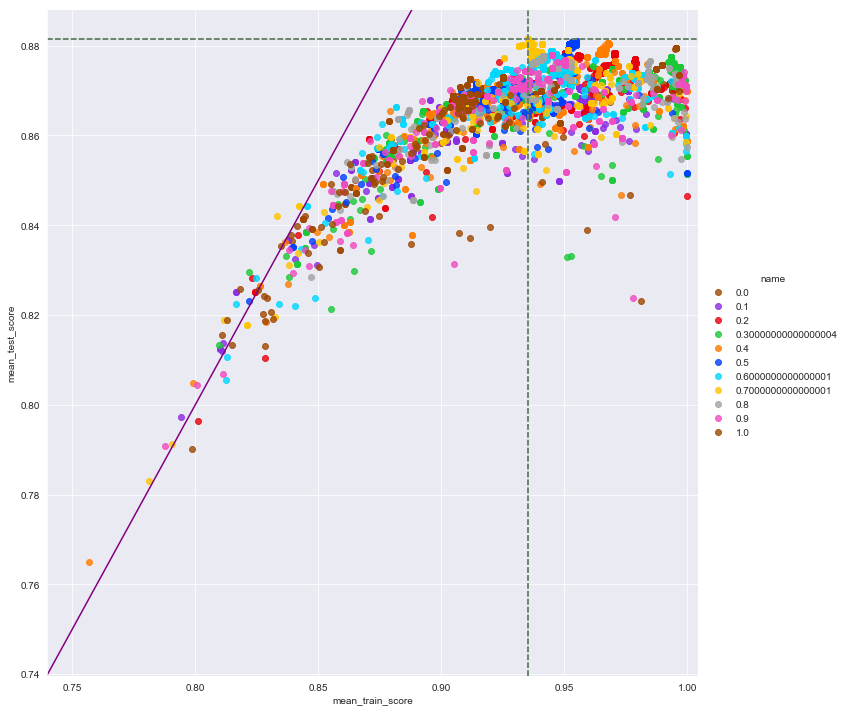

In [209]:
scip.cv_results_scatter_many(gene_mutation_prob_res, gene_mutation_prob_names)
scip.cv_results_scatter_many(gene_mutation_prob_res[::-1], gene_mutation_prob_names[::-1])

### all res

In [210]:
all_res = gene_mutation_prob_res + tournament_size_res + ratio_power_res + multi_pop_res + population_size_res

0
0.8750791463048958
1
0.8707089302076864
2
0.8783906509360923
3
0.8775583655913912
4
0.8806493524778035
5
0.8809599638378125
6
0.8788413752621219
7
0.8815246050614077
8
0.8776679609614907
9
0.8778857811445143
10
0.8794024655853693
11
0.8768529927852656
12
0.8806244875377429
13
0.8807543521802217
14
0.8790074502987282
15
0.880697078887706
16
0.8772366580960558
17
0.8775498972083401
18
0.8715532563624884
19
0.8762865236455518
20
0.8774794917404621
21
0.8792634784124074
22
0.8781720906242456
23
0.8742131577776349
24
0.8740546510662528
25
0.871441370902536
26
0.8784746502795109
27
0.8753293510173632
28
0.870586669732493
29
0.8698554846974033
30
0.8736816824001518
31
0.8657563219440415
32
0.8749535559001272
33
0.8768859836763282
34
0.877469784314657
35
0.8782470874609262
36
0.8790366933242016
37
0.8800876194301026
38
0.8751825338887911
39
0.879324453009049
40
0.8786554986331159
41
0.8766443303185877
42
0.8743219138689118
43
0.8729252122518748
44
0.8773920797333709
45
0.8807132861069278
46


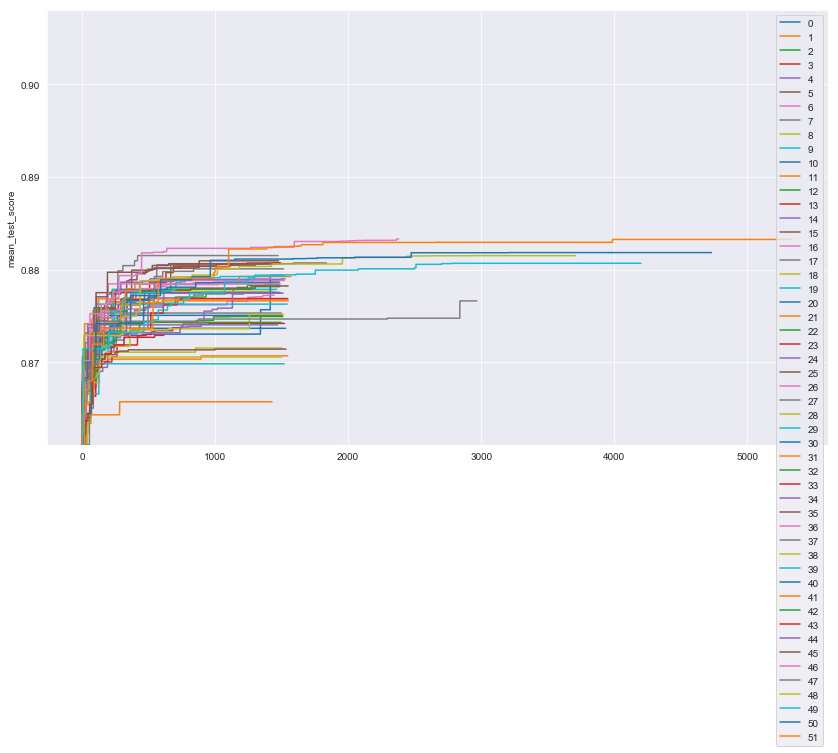

In [211]:
scip.cv_results_test_scores(all_res)

(0.7, 0.9106785470247841)

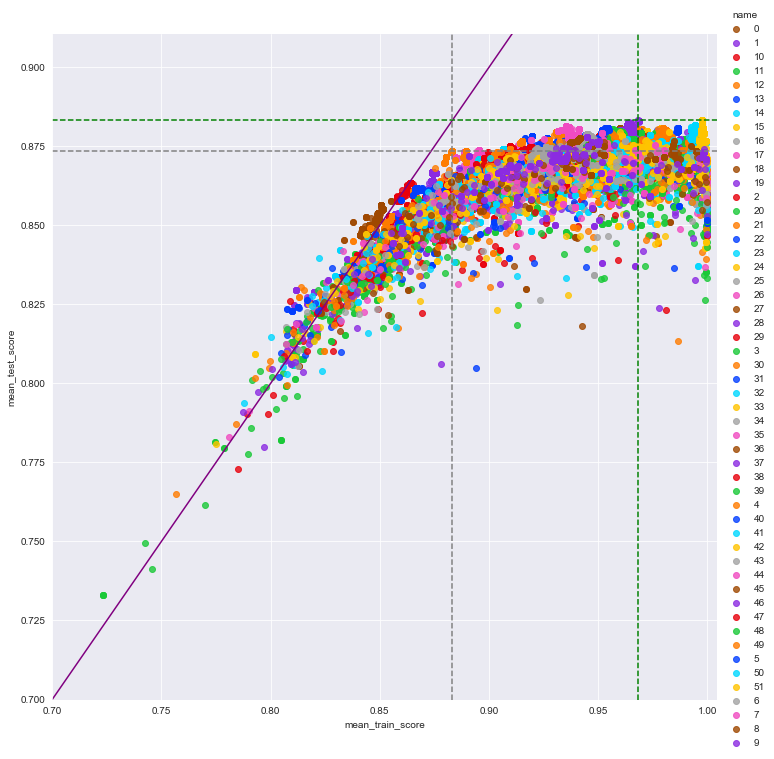

In [213]:
scip.cv_results_scatter_many(all_res)
plt.xlim(0.7)
plt.ylim(0.7)

In [132]:
from sklearn.base import clone
from sklearn.model_selection import check_cv
def get_cv_holdout_validation_curves(data, clf, model, cv=5):
    cv = check_cv(cv)
    all_test = []
    all_train = []
    all_holdout = []
    all_fulltrain = []
    all_cv_results = []
    for train, test in cv.split(data.X, data.y):    
        X_train = data.X.values[train]
        y_train = data.y.values[train]
        X_test = data.X.values[test]
        y_test = data.y.values[test]
        print('searching param space')
        clf.fit(X_train, y_train)

        print('refitting models on train')
        models = []
        for p in clf.cv_results_['params']:
            model = clone(model)
            model.set_params(**p)
            model.fit(X_train, y_train)
            models.append(model)

        print('scoring')
        scorer = get_scorer(scoring)
        fulltrain_scores = [scorer(model, X_train, y_train) for model in models]
        holdout_scores = [scorer(model, X_test, y_test) for model in models]
        train_scores = clf.cv_results_['mean_train_score']
        test_scores = clf.cv_results_['mean_test_score']
        
        df = pd.DataFrame(clf.cv_results_)
        df["holdout_score"] = holdout_scores
        df["fulltrain_score"] = fulltrain_scores
        idx = scip.get_cv_results_eff_idx(df, "mean_train_score", "mean_test_score")
        sdf = df.loc[idx]
        sdf = sdf.set_index("mean_train_score")
        sdf = sdf[~sdf.index.duplicated(keep='first')]

        all_fulltrain.append(sdf.fulltrain_score)
        all_holdout.append(sdf.holdout_score)
        all_test.append(sdf.mean_test_score)
        all_train.append(sdf.index)
        all_cv_results.append(clf.cv_results_)
        
    return all_train, all_test, all_fulltrain, all_holdout, all_cv_results
    
    
clf_rand = RandomizedSearchCV(model, ss_rand, scoring=scoring, 
                              cv=RepeatedStratifiedKFold(5, 5), 
                              n_jobs=10, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=1000,
                         )
    
all_train, all_test, all_fulltrain, all_holdout, all_cv_results = get_cv_holdout_validation_curves(data, clf_rand, model, cv = RepeatedStratifiedKFold(3, 5))
   

searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 3300 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done 8800 tasks      | elapsed:   23.9s
[Parallel(n_jobs=10)]: Done 16500 tasks      | elapsed:   45.6s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.2min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1620 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 4120 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done 7620 tasks      | elapsed:   25.4s
[Parallel(n_jobs=10)]: Done 12120 tasks      | elapsed:   41.2s
[Parallel(n_jobs=10)]: Done 17620 tasks      | elapsed:   59.1s
[Parallel(n_jobs=10)]: Done 24120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.3min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 3020 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 8020 tasks      | elapsed:   21.7s
[Parallel(n_jobs=10)]: Done 15020 tasks      | elapsed:   40.6s
[Parallel(n_jobs=10)]: Done 24020 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.2min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 4940 tasks      | elapsed:   12.5s
[Parallel(n_jobs=10)]: Done 9140 tasks      | elapsed:   23.2s
[Parallel(n_jobs=10)]: Done 14540 tasks      | elapsed:   37.8s
[Parallel(n_jobs=10)]: Done 21140 tasks      | elapsed:   57.2s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 4940 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done 9140 tasks      | elapsed:   23.7s
[Parallel(n_jobs=10)]: Done 14540 tasks      | elapsed:   38.4s
[Parallel(n_jobs=10)]: Done 21140 tasks      | elapsed:   55.3s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done 4940 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done 9140 tasks      | elapsed:   23.9s
[Parallel(n_jobs=10)]: Done 14540 tasks      | elapsed:   40.3s
[Parallel(n_jobs=10)]: Done 21140 tasks      | elapsed:   57.5s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 3580 tasks      | elapsed:    9.3s
[Parallel(n_jobs=10)]: Done 9580 tasks      | elapsed:   24.5s
[Parallel(n_jobs=10)]: Done 17980 tasks      | elapsed:   46.5s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 4740 tasks      | elapsed:   12.4s
[Parallel(n_jobs=10)]: Done 12740 tasks      | elapsed:   33.3s
[Parallel(n_jobs=10)]: Done 23940 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 3860 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done 10360 tasks      | elapsed:   29.0s
[Parallel(n_jobs=10)]: Done 19460 tasks      | elapsed:   52.9s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 4940 tasks      | elapsed:   12.5s
[Parallel(n_jobs=10)]: Done 9140 tasks      | elapsed:   23.3s
[Parallel(n_jobs=10)]: Done 14540 tasks      | elapsed:   38.0s
[Parallel(n_jobs=10)]: Done 21140 tasks      | elapsed:   57.1s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 3900 tasks      | elapsed:   10.5s
[Parallel(n_jobs=10)]: Done 10400 tasks      | elapsed:   28.3s
[Parallel(n_jobs=10)]: Done 19500 tasks      | elapsed:   53.4s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 4940 tasks      | elapsed:   13.3s
[Parallel(n_jobs=10)]: Done 9140 tasks      | elapsed:   24.9s
[Parallel(n_jobs=10)]: Done 14540 tasks      | elapsed:   39.8s
[Parallel(n_jobs=10)]: Done 21140 tasks      | elapsed:   57.5s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done 4940 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done 9140 tasks      | elapsed:   24.7s
[Parallel(n_jobs=10)]: Done 14540 tasks      | elapsed:   40.1s
[Parallel(n_jobs=10)]: Done 21140 tasks      | elapsed:   57.7s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 3900 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done 10400 tasks      | elapsed:   27.4s
[Parallel(n_jobs=10)]: Done 19500 tasks      | elapsed:   52.5s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.2min finished


refitting models on train
scoring
searching param space
Fitting 25 folds for each of 1000 candidates, totalling 25000 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done 4940 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done 9140 tasks      | elapsed:   23.8s
[Parallel(n_jobs=10)]: Done 14540 tasks      | elapsed:   38.6s
[Parallel(n_jobs=10)]: Done 21140 tasks      | elapsed:   56.2s
[Parallel(n_jobs=10)]: Done 25000 out of 25000 | elapsed:  1.1min finished


refitting models on train
scoring


name: 	test	mean:	0.6942371588542788	std:	0.0040160914551086325
name: 	holdout	mean:	0.7495960714410113	std:	0.04594854229965275


(0.7, 0.8940731515315801)

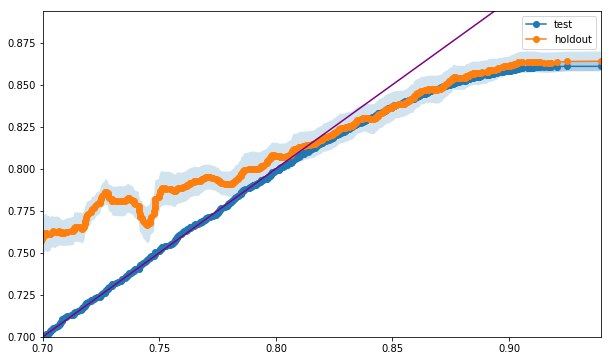

In [157]:
# for x in all_holdout:
#     plt.plot(x)

df = pd.DataFrame(all_test).interpolate(axis=1).dropna(axis=1)
scip.range_df(df, name="test")

df = pd.DataFrame(all_holdout).interpolate(axis=1).dropna(axis=1)
scip.range_df(df, name="holdout")

plt.legend()

# for x in all_test:
#     plt.plot(x)

scip.diag_line()
    
plt.xlim(0.7)
plt.ylim(0.7)



0.8850604262840511 0.8545326833049883 None 876


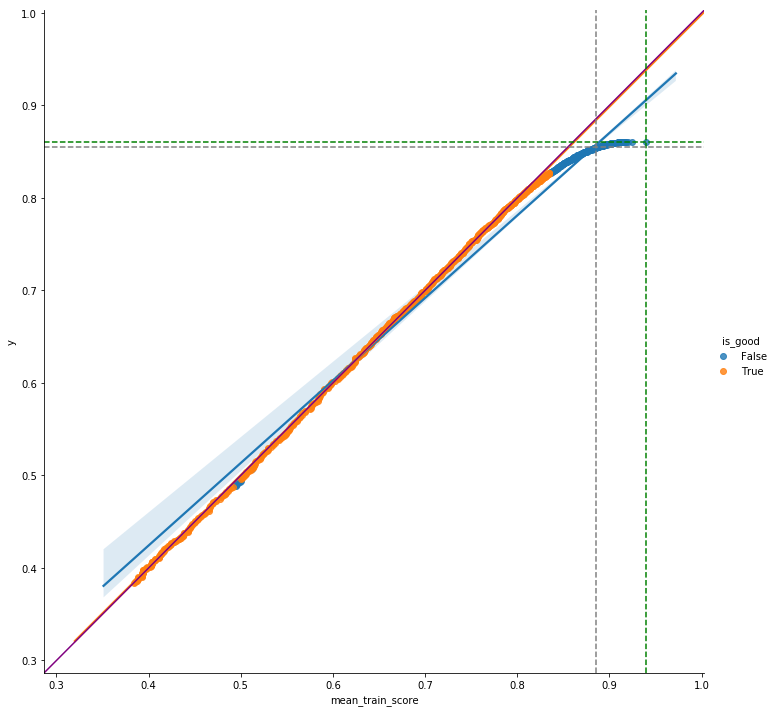

In [178]:
df_all_fulltrain = pd.DataFrame(all_train).interpolate(axis=1).dropna(axis=1).mean()
df_all_holdout = pd.DataFrame(all_test).interpolate(axis=1).dropna(axis=1).mean()

scip.cv_results_scatter_xy(pd.Series(df_all_holdout.index), pd.Series(df_all_holdout.values))


0.8809143190758953 0.8545562940169072 None 0.8768696206027998


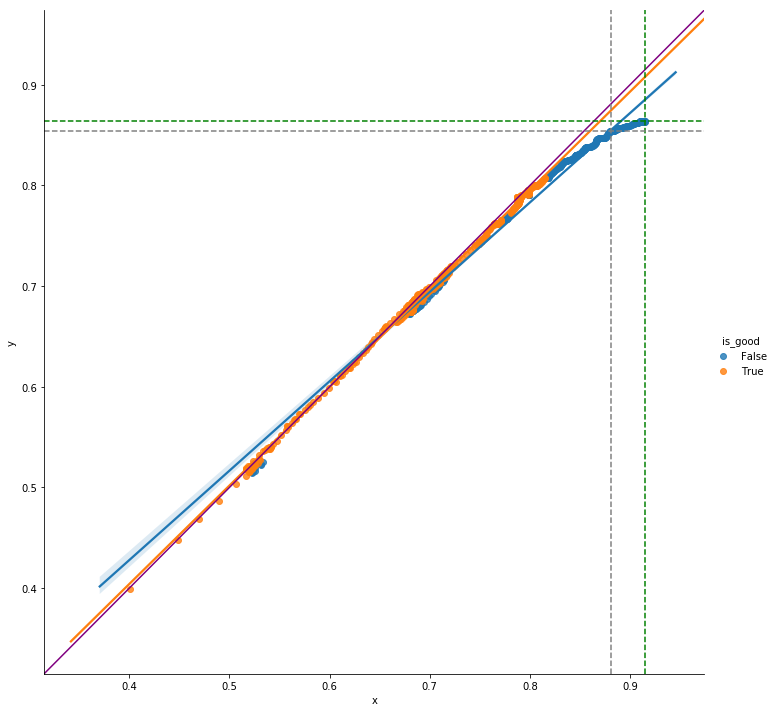

In [153]:
df_all_fulltrain = pd.DataFrame(all_fulltrain).interpolate(axis=1).dropna(axis=1).mean()
df_all_holdout = pd.DataFrame(all_holdout).interpolate(axis=1).dropna(axis=1).mean()

scip.cv_results_scatter_xy(df_all_fulltrain, df_all_holdout)


In [152]:
%debug

> /Users/user/git/kaggle/titanic/pandas/_libs/hashtable_class_helper.pxi(388)pandas._libs.hashtable.Float64HashTable.get_item()

ipdb> u
> /Users/user/git/kaggle/titanic/pandas/_libs/hashtable_class_helper.pxi(382)pandas._libs.hashtable.Float64HashTable.get_item()

ipdb> u
> /Users/user/git/kaggle/titanic/pandas/_libs/index.pyx(132)pandas._libs.index.IndexEngine.get_loc()

ipdb> u
> /Users/user/git/kaggle/titanic/pandas/_libs/index.pyx(108)pandas._libs.index.IndexEngine.get_loc()

ipdb> u
> /Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/pandas/core/indexes/base.py(2658)get_loc()
   2656                 return self._engine.get_loc(key)
   2657             except KeyError:
-> 2658                 return self._engine.get_loc(self._maybe_cast_indexer(key))
   2659         indexer = self.get_indexer([key], method=method, tolerance=tolerance)
   2660         if indexer.ndim > 1 or indexer.size > 1:

ipdb> u
> /Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/pandas

ipdb> 
> /Users/user/git/datasci/sci/plots.py(44)get_cv_results_eff_idx()
     42     idx = []
     43     for b in bins:
---> 44         tdf = df[df[xname] <= b][-10:]
     45         idx.append(tdf.sort_values(yname, ascending=False).index[0])
     46     #     idx.append(df.query(f'mean_train_score <= {b}').sort_values("mean_test_score", ascending=False).index[0])

ipdb> b
ipdb> bins
array([0.40103336, 0.40622521, 0.41141706, 0.41660891, 0.42180076,
       0.42699261, 0.43218447, 0.43737632, 0.44256817, 0.44776002,
       0.45295187, 0.45814372, 0.46333558, 0.46852743, 0.47371928,
       0.47891113, 0.48410298, 0.48929483, 0.49448669, 0.49967854,
       0.50487039, 0.51006224, 0.51525409, 0.52044595, 0.5256378 ,
       0.53082965, 0.5360215 , 0.54121335, 0.5464052 , 0.55159706,
       0.55678891, 0.56198076, 0.56717261, 0.57236446, 0.57755631,
       0.58274817, 0.58794002, 0.59313187, 0.59832372, 0.60351557,
       0.60870742, 0.61389928, 0.61909113, 0.62428298, 0.62947483,
       

ipdb> df[xname] <= b
mean_train_score
0.38384     True
0.38549     True
0.38668     True
0.38700     True
0.38779     True
0.40327     True
0.40292     True
0.40320     True
0.38802     True
0.40328     True
0.40279     True
0.39343     True
0.39342     True
0.40276     True
0.39327    False
0.39312    False
0.39344    False
0.39680    False
0.39309    False
0.39297    False
0.40259    False
0.39624    False
0.39292    False
0.39427    False
0.40335    False
0.39362    False
0.39421    False
0.39371    False
0.40222    False
0.39436    False
0.38821    False
0.39249    False
0.39715    False
0.39784    False
0.40338    False
0.40192    False
0.39871    False
0.39245    False
0.38825    False
0.40364    False
0.38866    False
0.40533    False
0.40690    False
0.40703    False
0.41084    False
0.40735    False
0.41141    False
0.41173    False
0.40832    False
0.41080    False
0.41192    False
0.41244    False
0.41323    False
0.41357    False
0.41705    False
0.41701    False
0.41374   

ipdb> df[df[xname] <= b][-10:]
*** KeyError: -10.0
ipdb> df[df[xname] <= b]
                       x       y   ratio
mean_train_score                        
0.38384          0.40103 0.39939 0.99590
0.38549          0.44865 0.44787 0.99826
0.38668          0.46993 0.46885 0.99768
0.38700          0.48942 0.48659 0.99422
0.38779          0.50642 0.50304 0.99334
0.40327          0.51643 0.51907 1.00511
0.40292          0.51643 0.51814 1.00330
0.40320          0.51644 0.51863 1.00425
0.38802          0.51675 0.51164 0.99012
0.40328          0.51822 0.52113 1.00562
0.40279          0.51901 0.52064 1.00314
0.39343          0.51933 0.51557 0.99276
0.39342          0.51941 0.51520 0.99189
0.40276          0.52029 0.52138 1.00209
ipdb> df[df[xname] <= b].iloc[-10:]
                       x       y   ratio
mean_train_score                        
0.38779          0.50642 0.50304 0.99334
0.40327          0.51643 0.51907 1.00511
0.40292          0.51643 0.51814 1.00330
0.40320          0.51644 0.

name: 	holdout	mean:	0.7616444419329504	std:	0.02109630786406136
name: 	train	mean:	0.7181846577938665	std:	0.0029744411344960753
name: 	test	mean:	0.7097463322264774	std:	0.003514340644781599


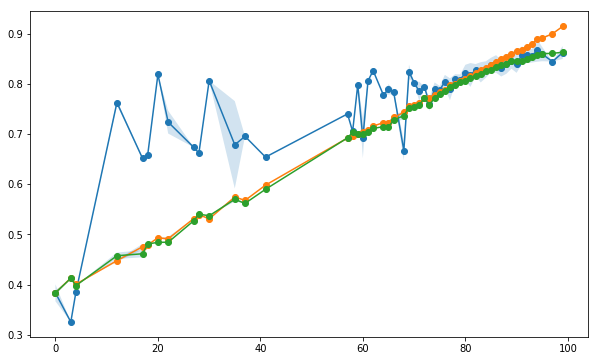

In [47]:
scip.range_df(all_holdout, name='holdout')
scip.range_df(all_train, name='train')
scip.range_df(all_test, name='test')

## RandomizedSearchCV

In [ ]:
cv = RepeatedStratifiedKFold(5, 3)
clf_rand = RandomizedSearchCV(model, ss_rand, scoring=scoring, cv=cv, n_jobs=10, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=10000,
                         )
clf_rand.fit(data.X_train, data.y_train)
scip.bayes_search_results_scatter(clf_rand)


In [ ]:
# using n_iter =10_000 instead of 1_000
cv = RepeatedStratifiedKFold(3, 10)
clf_rand = RandomizedSearchCV(model, ss_rand, scoring=scoring, cv=cv, n_jobs=10, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=10000,
                         )
clf_rand.fit(data.X_train, data.y_train)
scip.bayes_search_results_scatter(clf_rand)


In [ ]:
# using res=100 instead of res=5 for search space
cv = RepeatedStratifiedKFold(3, 10)
clf_rand = RandomizedSearchCV(model, ss_rand, scoring=scoring, cv=cv, n_jobs=10, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=1000,
                         )
clf_rand.fit(data.X_train, data.y_train)
scip.bayes_search_results_scatter(clf_rand)


In [ ]:
# using res=100 instead of res=5 for search space
import sci.learn_bayes
from sci.learn_bayes import _check_search_spaces

ss = _check_search_spaces(model, ss_rand)
cv = RepeatedStratifiedKFold(3, 3)
clf_rand2 = RandomizedSearchCV(model, ss, scoring=scoring, cv=cv, n_jobs=10, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=200,
                         )
clf_rand2.fit(data.X_train, data.y_train)
scip.bayes_search_results_scatter(clf_rand2)


In [34]:
from sklearn.base import clone
models = []
for p in clf_rand.cv_results_['params']:
    model = clone(model)
    model.set_params(**p)
    model.fit(data.X_train, data.y_train)
    models.append(model)
scorer = get_scorer(scoring)

In [35]:
holdout_scores = [scorer(model, data.X_test, data.y_test) for model in models]
fulltrain_scores = [scorer(model, data.X_train, data.y_train) for model in models]

In [36]:
df = pd.DataFrame(clf_rand.cv_results_)
df["holdout_score"] = holdout_scores
df["fulltrain_scores"] = fulltrain_scores
# df["ratio"] = df.mean_test_score  / df.mean_train_score


0.8775561141067754 0.8491669292862764 None 803


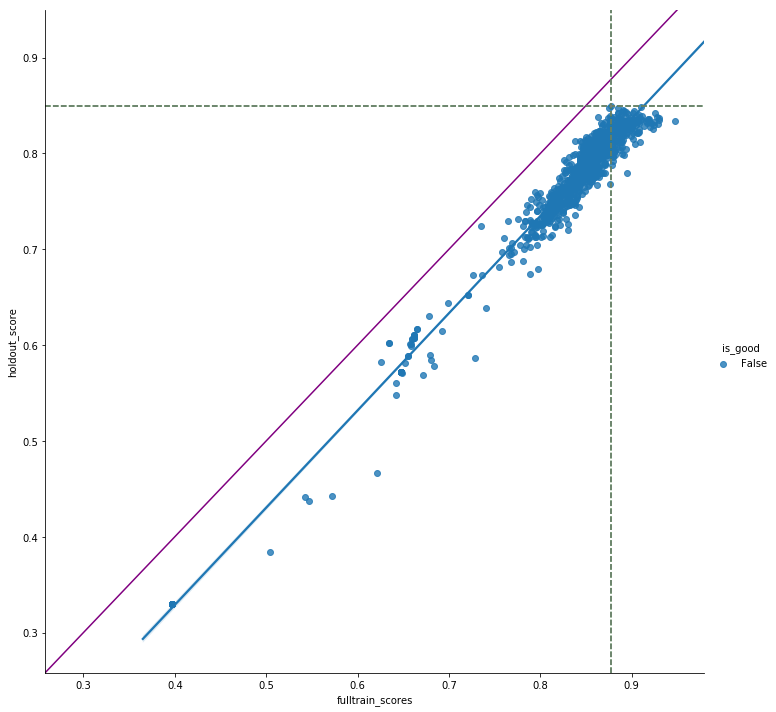

In [37]:
scip.cv_results_scatter_xy(df.fulltrain_scores, df.holdout_score)

[<matplotlib.lines.Line2D at 0x1a23d08588>]

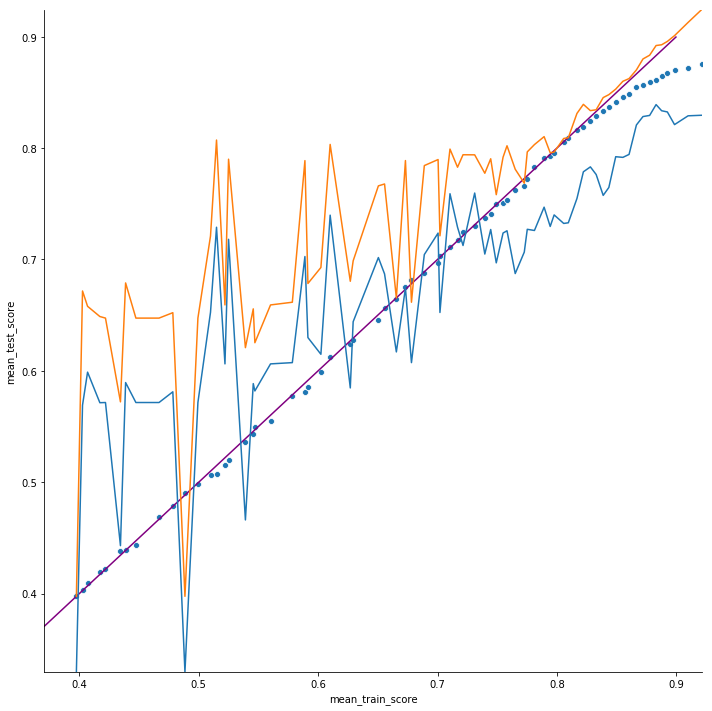

In [38]:
idx = scip.get_cv_results_eff_idx(df, "mean_train_score", "mean_test_score")
sdf = df.loc[idx]
sdf = sdf.reset_index()
sdf = sdf[~sdf["index"].duplicated(keep='first')]

# sdf.index = np.arange(sdf.shape[0])
sns.relplot('mean_train_score', 'mean_test_score', data=sdf, aspect=1, height=10)
# sns.lmplot('mean_train_score', 'fulltrain_scores', data=sdf, aspect=1, height=10)
# sns.lmplot('fulltrain_scores', 'holdout_score', data=sdf, aspect=1, height=10)
# sns.lmplot('mean_train_score', 'holdout_score', data=sdf, aspect=1, height=10)
# sns.lmplot('mean_test_score', 'holdout_score', data=sdf, aspect=1, height=10)
# sns.lmplot('ratio', 'holdout_score', data=sdf, aspect=1, height=10)
import sci.plots as scip
scip.diag_line()
plt.plot(sdf.mean_train_score, sdf.holdout_score)
plt.plot(sdf.mean_train_score, sdf.fulltrain_scores)
# plt.plot(sdf.mean_train_score, sdf.mean_test_score)


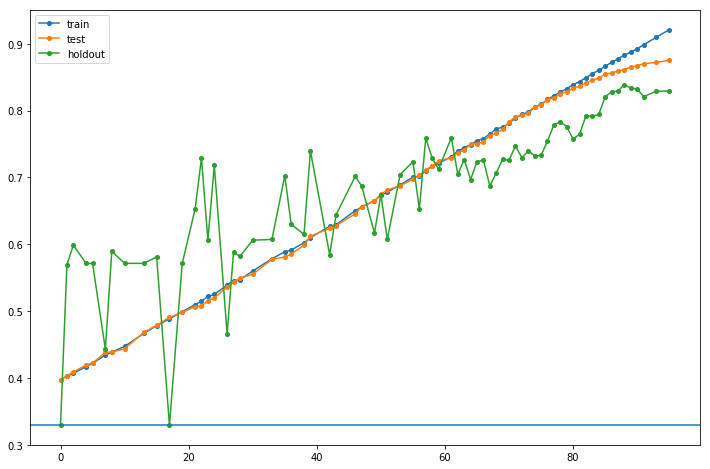

In [39]:
# the implied "complexity" validation curve
plt.figure(figsize=(12, 8))
plt.plot(sdf.mean_train_score, label="train", marker='o', markersize=4)
plt.plot(sdf.mean_test_score, label="test", marker='o', markersize=4)
plt.plot(sdf.holdout_score, label="holdout", marker='o', markersize=4)
plt.legend()

plt.axhline(average_precision_score(data.y_test, np.zeros_like(data.y_test)+1))

## hyperband

clf_rand runs much faster and gets better results

In [19]:
from hyperband import HyperbandSearchCV



clf_hband = HyperbandSearchCV(model, ss_rand, 
#                            resource_param='n_estimators',
                           scoring='accuracy',
                          return_train_score=True,
                          max_iter=1000,
                          n_jobs=10,
                          cv=3)
clf_hband.fit(X, y)
# print(search.best_params_)

HyperbandSearchCV(cv=None, error_score='raise',
         estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
         eta=3, iid=True, max_iter=1000, min_iter=1, n_jobs=1,
         param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11659feb8>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x111c6de10>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1168205f8>, 'subsample': <scipy.stats....168330b8>, 'colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1168335c0>},
         pre_dispatch='2*n_jobs', random_state=None, refit=True,
  

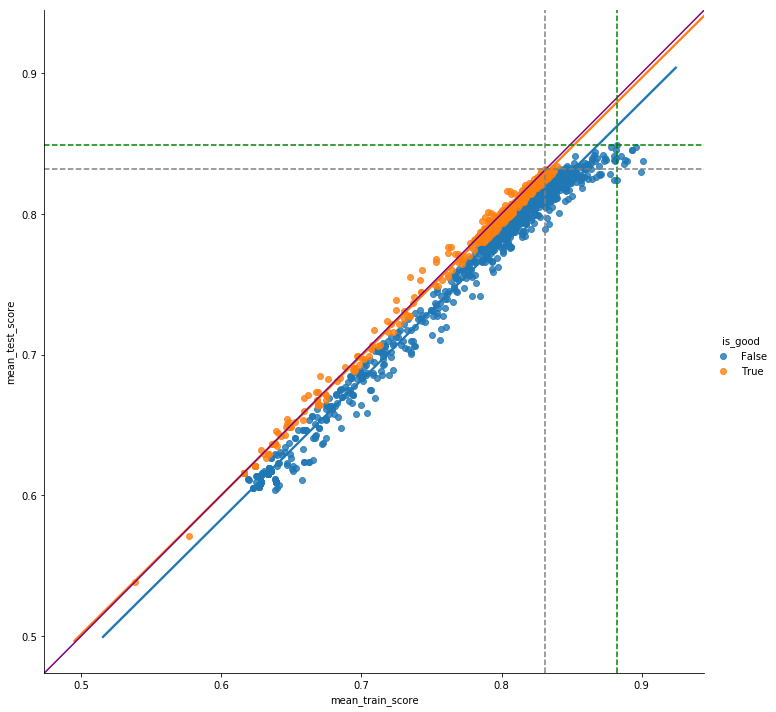

In [20]:
scip.cv_results_scatter(clf_hband)

In [24]:
clf_rand = RandomizedSearchCV(model, ss_rand, scoring=scoring, cv=3, n_jobs=n_jobs, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=1600,
                         )
clf_rand.fit(X, y)


Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


[Parallel(n_jobs=10)]: Done  80 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 980 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done 2480 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done 4580 tasks      | elapsed:   16.5s
[Parallel(n_jobs=10)]: Done 4800 out of 4800 | elapsed:   17.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=1600, n_jobs=10,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11659feb8>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x111c6de10>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1168205f8>, 'subsample': <scipy.stats....168330b8>, 'colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1168335c0>},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          

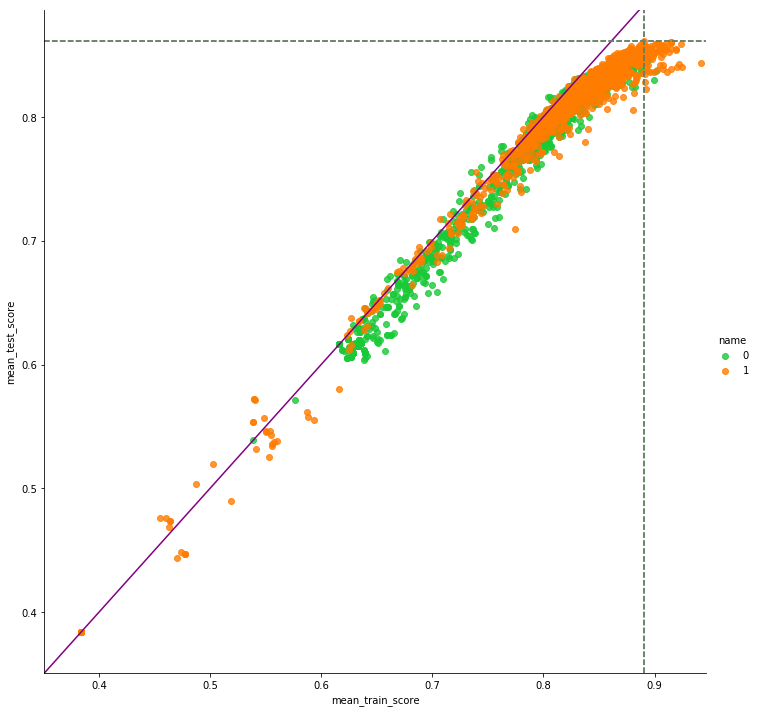

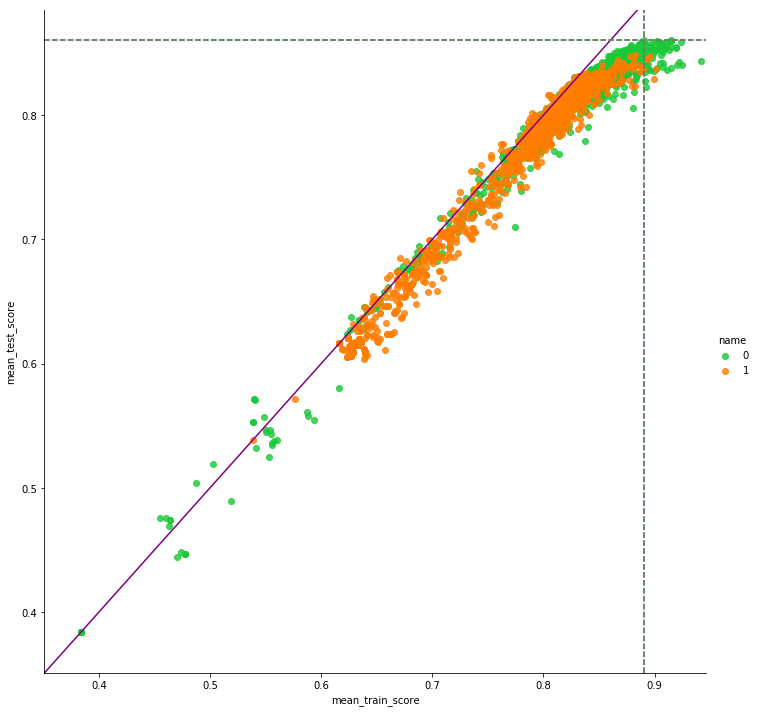

In [26]:
scip.cv_results_scatter_many([search, clf_rand])
scip.cv_results_scatter_many([search, clf_rand][::-1])

In [26]:
from civismlext.hyperband import HyperbandSearchCV as HyperbandSearchCV2

from hyperband import HyperbandSearchCV



clf_hband = HyperbandSearchCV2(model, ss_rand, 
                               cost_parameter_max={'n_estimators': 100},
                               cost_parameter_min={'n_estimators': 30},
                           scoring='accuracy',
                          return_train_score=True,
                          n_jobs=10,
                          cv=3,
                              eta=1.01)
clf_hband.fit(X, y)
# print(search.best_params_)

HyperbandSearchCV(cost_parameter_max={'n_estimators': 100},
         cost_parameter_min={'n_estimators': 30}, cv=3,
         error_score='raise',
         estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
         eta=1.01, iid=True, n_jobs=10,
         param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11af41e48>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11b23a278>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11b31ab38>, 'subsample': <scipy.stats....1b32f550>, 'colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11b32

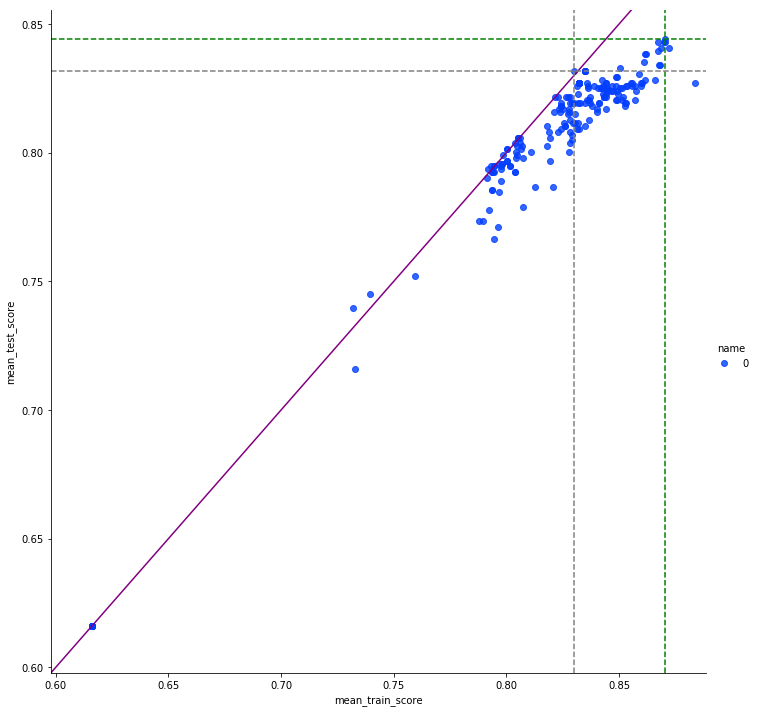

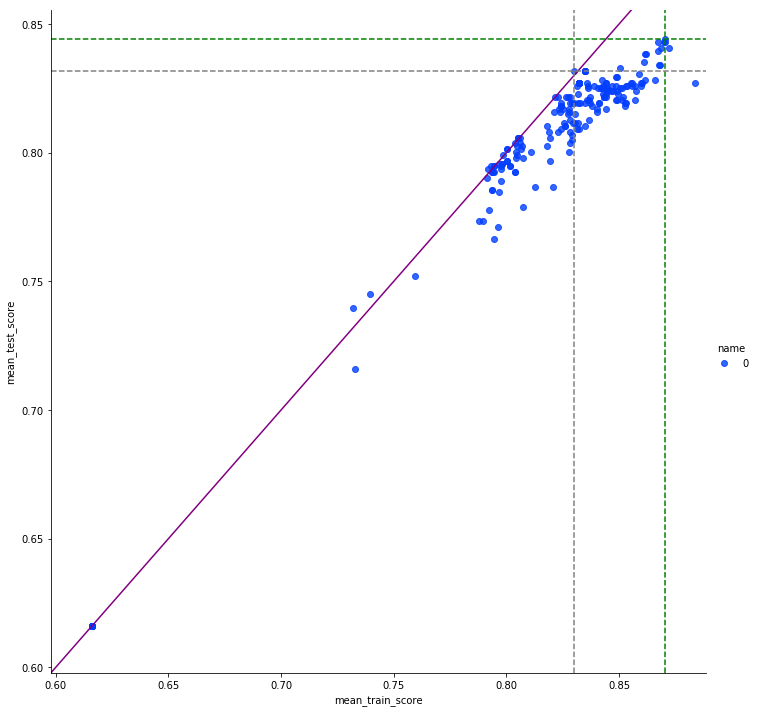

In [24]:
scip.cv_results_scatter_many([clf_hband])
scip.cv_results_scatter_many([clf_hband][::-1])

In [303]:
k = 'learning_rate'
n = 1000
x_rand = ss_rand[k].rvs(n)
x_hopt = [sample(ss_hopt[k]) for _ in range(n)]

ss = scit.map_ss_to_grid(ss_bayes, res=n)
x_grid = ss[k]

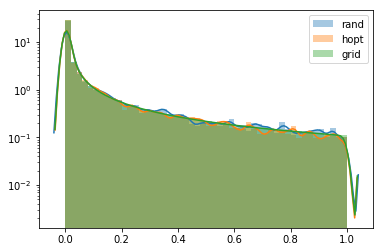

In [307]:
sns.distplot(x_rand, label='rand')
sns.distplot(x_hopt, label='hopt')
sns.distplot(x_grid, label='grid')
plt.legend()
plt.yscale('log')
# plt.xscale('log')

In [313]:
ss_bayes = {
    'n_estimators': (30, 100),
    'learning_rate': (0.0001, 1.0, 'log-uniform'),
    'max_depth': (1, 20),
    'subsample': (0.01, 1.0, 'uniform'),
    'gamma': (1e-09, 10, 'log-uniform'),
    'min_child_weight': (0, 10),
    'reg_lambda': (1e-09, 1000, 'log-uniform'),
    'reg_alpha': (1e-09, 1.0, 'log-uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'colsample_bylevel': (0.01, 1.0, 'uniform'),
}

ss_rand = {
    'n_estimators': scipy.stats.randint(30, 100+1),
    'learning_rate': log_uniform(np.log(0.0001), np.log(1)),
    'max_depth': scipy.stats.randint(1, 20),
    'subsample': scipy.stats.uniform(0.01, 1.0-0.01),
    'gamma': log_uniform(np.log(1e-09), np.log(10)),
    'min_child_weight': scipy.stats.randint(0, 10+1),
    'reg_lambda': log_uniform(np.log(1e-09), np.log(1000)),
    'reg_alpha': log_uniform(np.log(1e-09), np.log(1)),
    'colsample_bytree': scipy.stats.uniform(0.01, 1.0-0.01),
    'colsample_bylevel': scipy.stats.uniform(0.01, 1.0-0.01),
}

ss_hopt = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 30, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
    'subsample': hp.uniform('subsample', 0.01, 1),
    'gamma': hp.loguniform('gamma', np.log(1e-09), np.log(10)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 0, 10, 1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-09), np.log(1000)),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-09), np.log(1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.01, 1),
}

In [12]:
#https://github.com/hyperopt/hyperopt/wiki/FMin

from hyperopt import hp
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample


sample(ss_hopt)
# def _xgboost_max_depth(name):
#     return scope.int(hp.uniform(name, 1, 11))

# def _xgboost_learning_rate(name):
#     return hp.loguniform(name, np.log(0.0001), np.log(0.5)) - 0.0001

# def _xgboost_n_estimators(name):
#     return scope.int(hp.quniform(name, 100, 6000, 200))

# def _xgboost_gamma(name):
#     return hp.loguniform(name, np.log(0.0001), np.log(5)) - 0.0001

# def _xgboost_min_child_weight(name):
#     return scope.int(hp.loguniform(name, np.log(1), np.log(100)))

# def _xgboost_subsample(name):
#     return hp.uniform(name, 0.5, 1)

# def _xgboost_colsample_bytree(name):
#     return hp.uniform(name, 0.5, 1)

# def _xgboost_colsample_bylevel(name):
#     return hp.uniform(name, 0.5, 1)

# def _xgboost_reg_alpha(name):
#     return hp.loguniform(name, np.log(0.0001), np.log(1)) - 0.0001

# def _xgboost_reg_lambda(name):
#     return hp.loguniform(name, np.log(1), np.log(4))


{'colsample_bylevel': 0.49191487054700234,
 'colsample_bytree': 0.47172835260331364,
 'gamma': 2.1816947283691817e-07,
 'learning_rate': 0.006172604416281625,
 'max_depth': 15,
 'min_child_weight': 4,
 'n_estimators': 44,
 'reg_alpha': 0.0005186625071287959,
 'reg_lambda': 2.915537149593622e-09,
 'subsample': 0.3799696037279844}

In [353]:
from sci.tune import HyperoptSearchCV

In [354]:
clf_hopt = HyperoptSearchCV(model, ss_hopt, n_iter=50, cv=5, scoring='accuracy')
clf_hopt.fit(X, y)


100%|██████████| 50/50 [00:09<00:00,  4.52it/s, best loss: 0.1425165092256968]


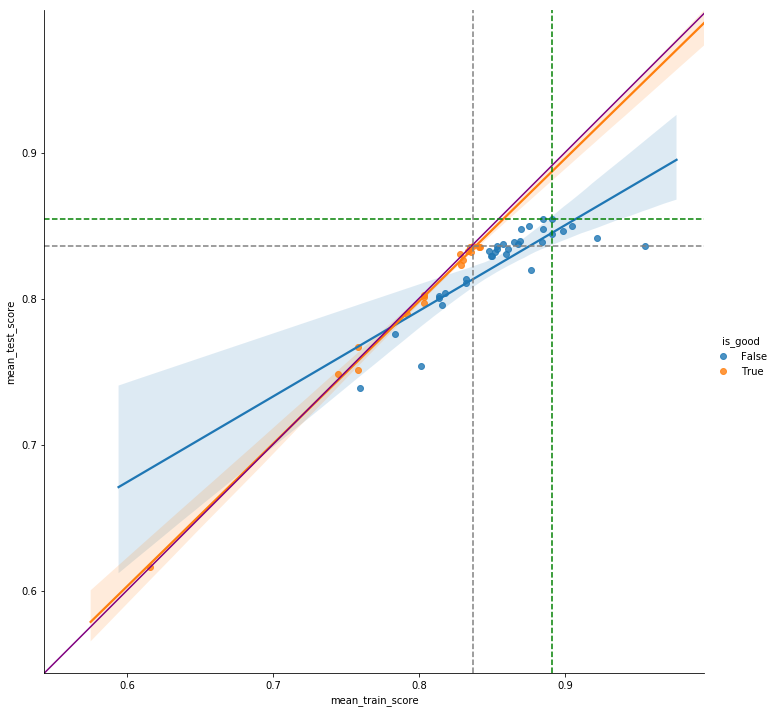

In [345]:
scip.cv_results_scatter(clf_hopt)

In [322]:
from hyperopt import fmin, STATUS_OK, Trials
from sklearn.model_selection import *
from functools import partial

algo = partial(mix.suggest, p_suggest=[
                    (0.1, rand.suggest),
                    (0.2, anneal.suggest),
                    (0.7, tpe.suggest)])
# algo = rand.suggest
algo = tpe.suggest
# algo = anneal.suggest

def score(params):
    model.set_params(**params)
    res = cross_validate(model, data.X, data.y, scoring="accuracy", cv=5, n_jobs=1)
#     return np.mean(res['test_score'])
    return {
        'status': STATUS_OK, 
        'loss': 1-np.mean(res['test_score']), 
        'loss_variance': np.std(res['test_score']),
        'mean_train_score': np.mean(res['train_score']), 
        'mean_test_score': np.mean(res['test_score']), 
        'params': params
    }
# from tqdm import tqdm
# tqdm.get_lock().locks = []
# trials = Trials()
res = fmin(score, ss_hopt, algo=algo, max_evals=450, trials=trials)
res


 28%|██▊       | 97/350 [00:27<01:30,  2.78it/s, best loss: 0.14254183028718115]


 55%|█████▌    | 193/350 [01:00<01:05,  2.41it/s, best loss: 0.13914572270884284]


 83%|████████▎ | 289/350 [01:42<00:28,  2.11it/s, best loss: 0.13914572270884284]


100%|██████████| 350/350 [02:02<00:00,  3.12it/s, best loss: 0.13914572270884284]


{'colsample_bylevel': 0.7883425457853572,
 'colsample_bytree': 0.9996213058897909,
 'gamma': 0.3083812253700882,
 'learning_rate': 0.000515175107607895,
 'max_depth': 19.0,
 'min_child_weight': 1.0,
 'n_estimators': 62.0,
 'reg_alpha': 3.6673740749078258e-06,
 'reg_lambda': 8.252239948174165e-06,
 'subsample': 0.7368609079165391}

In [92]:
# df_mix = pd.DataFrame(trials.results)

In [87]:
# df_anneal = pd.DataFrame(trials.results)

In [327]:
df_tpe = pd.DataFrame(trials.results)
df = df_tpe

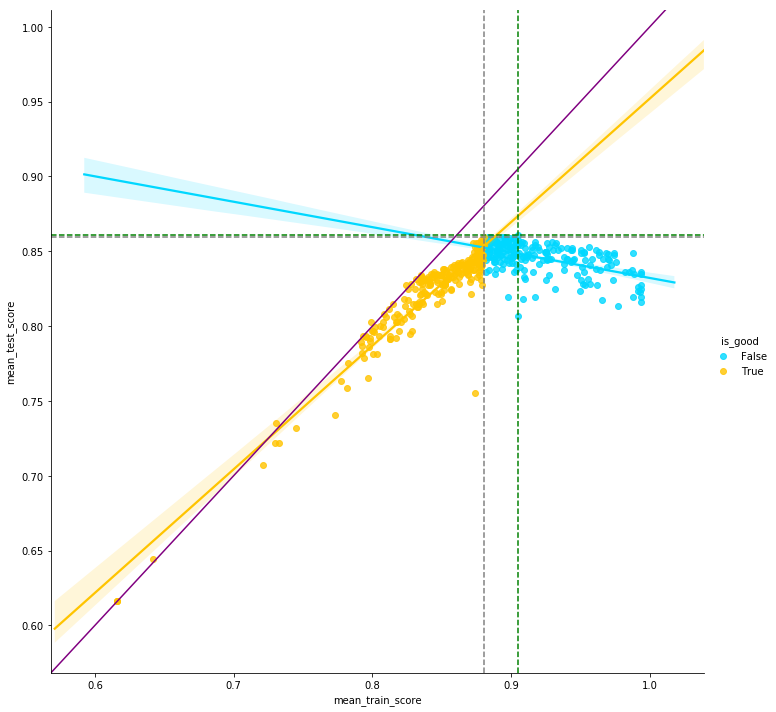

In [328]:
# df = df_mix
scip.cv_results_scatter_df(df)

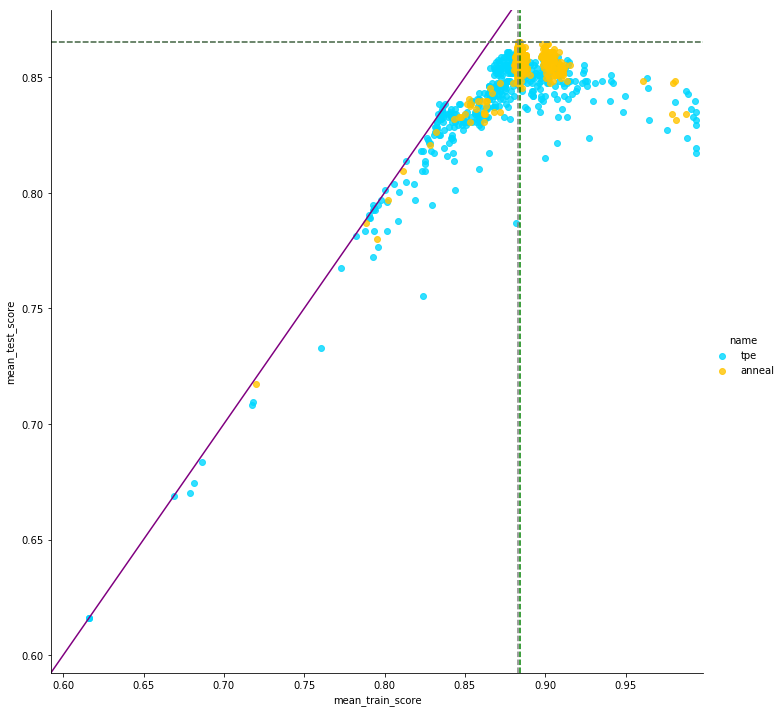

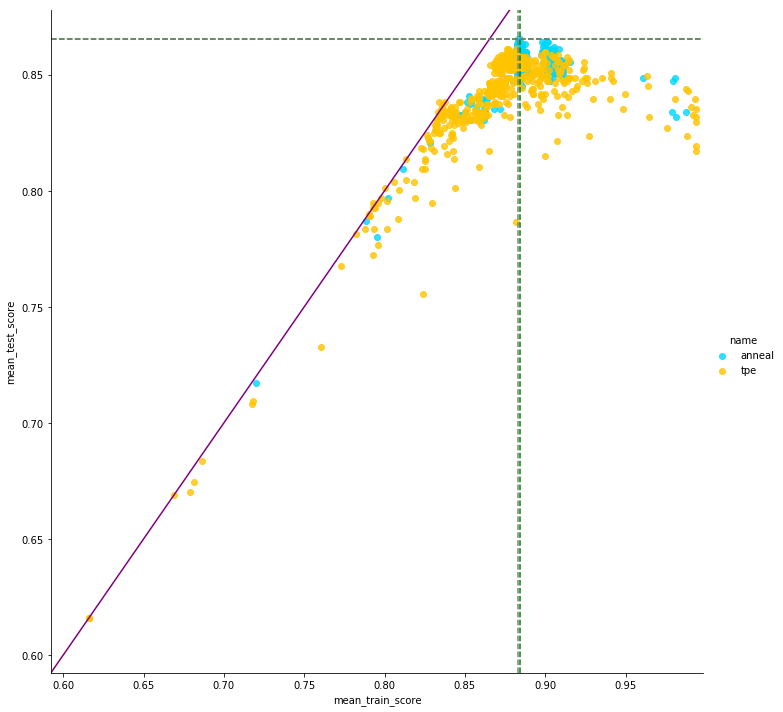

In [89]:
scip.cv_results_scatter_many({'tpe': df_tpe, 'anneal': df_anneal})
scip.cv_results_scatter_many({'anneal': df_anneal, 'tpe': df_tpe})

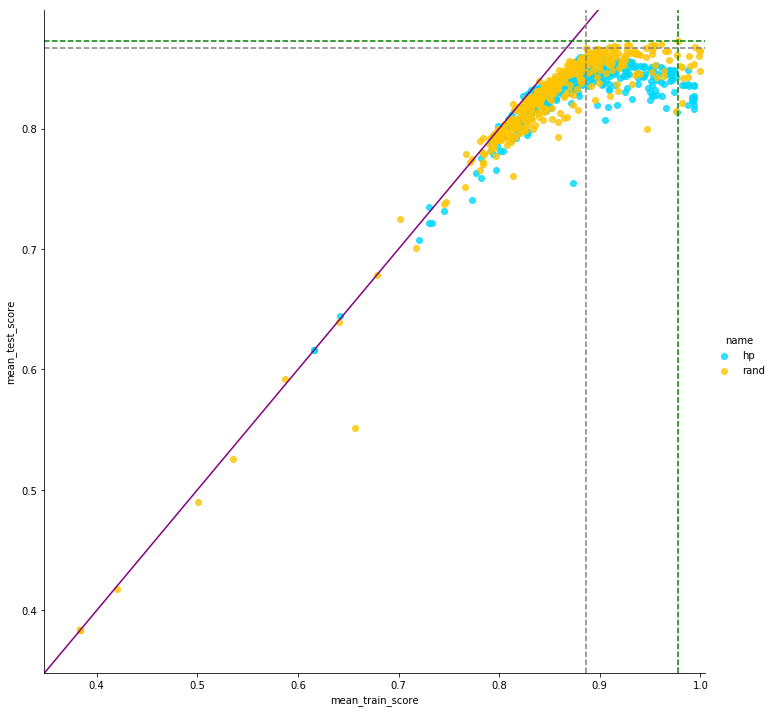

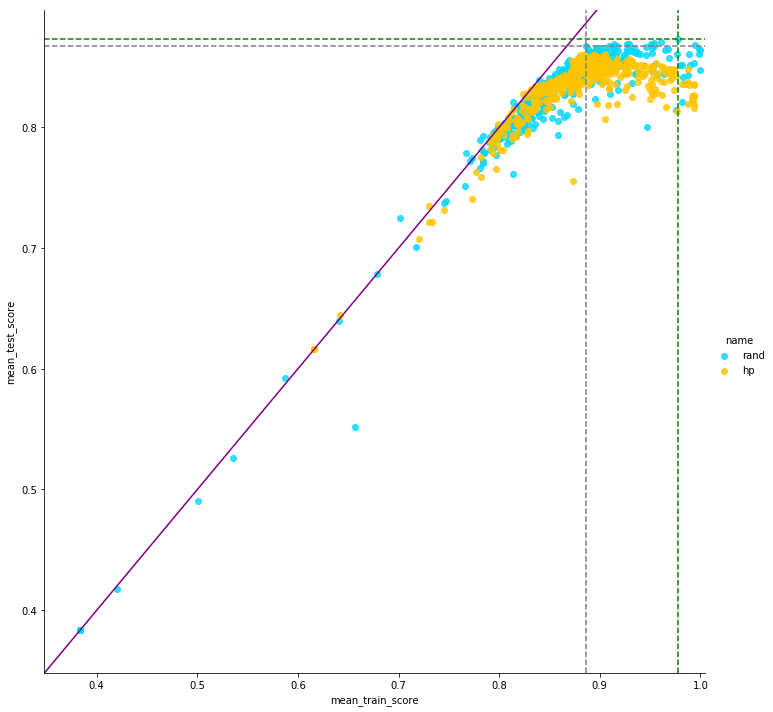

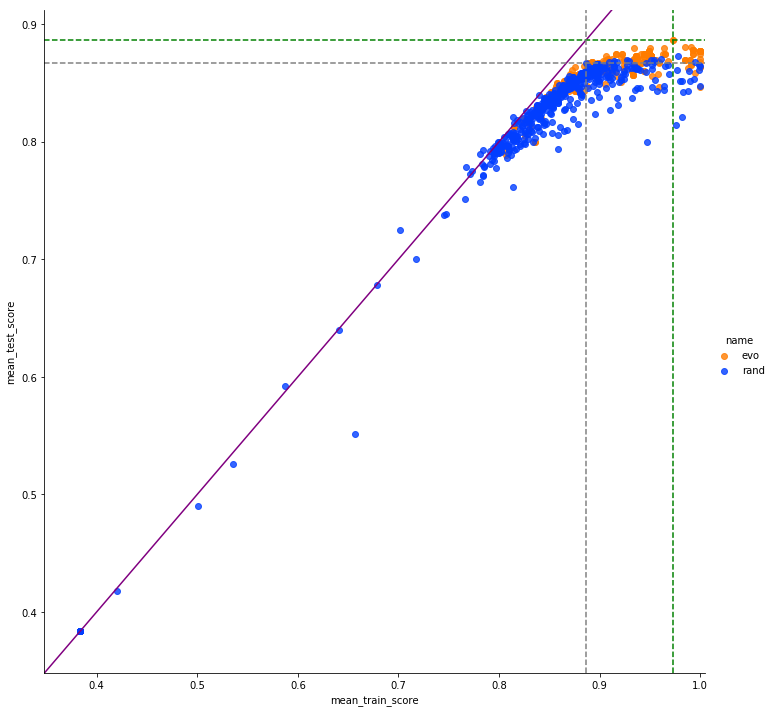

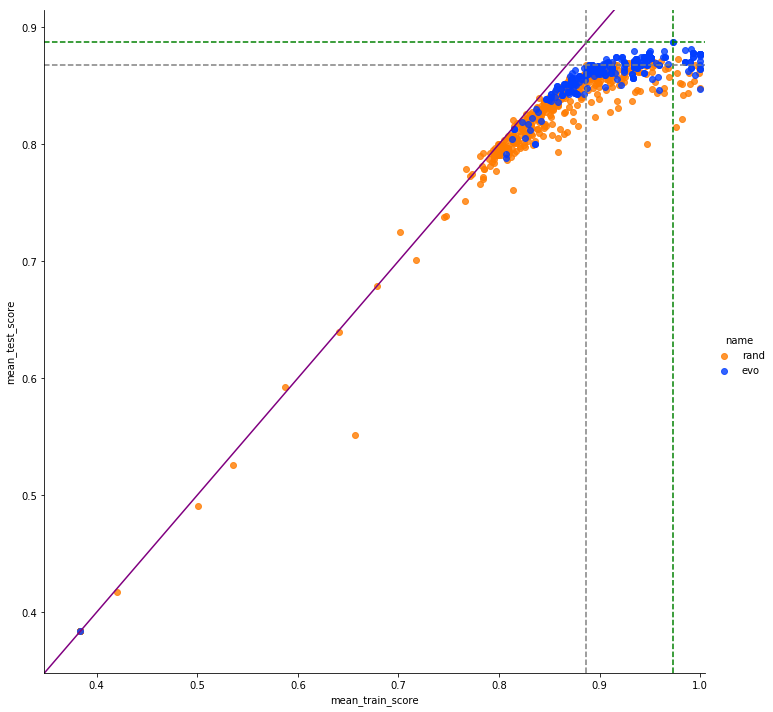

In [331]:
scip.cv_results_scatter_many({'hp': df, 'rand': clf_rand})
scip.cv_results_scatter_many({'rand': clf_rand, 'hp': df})
scip.cv_results_scatter_many({'evo': clf_evo, 'rand': clf_rand})
scip.cv_results_scatter_many({'rand': clf_rand, 'evo': clf_evo})


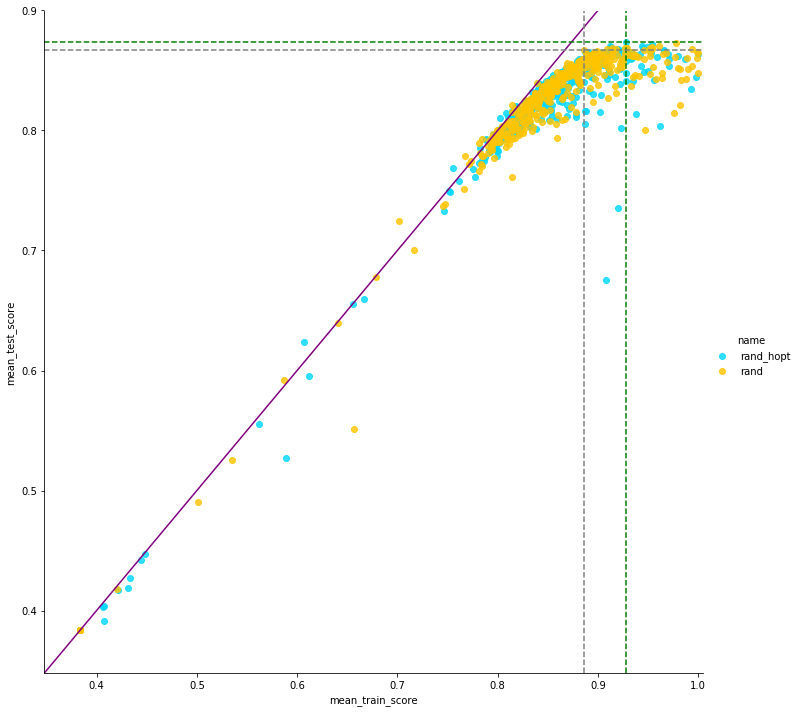

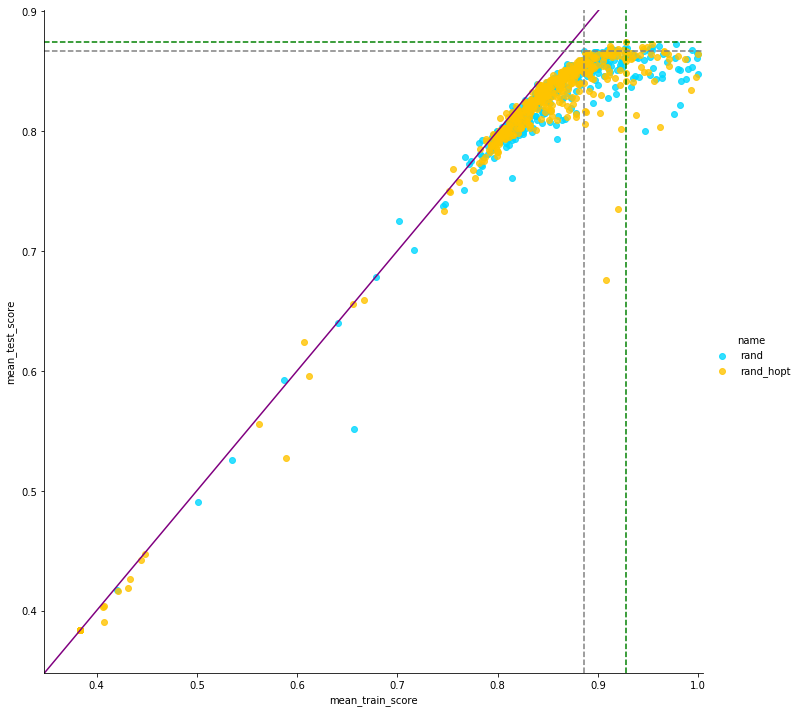

In [315]:
scip.cv_results_scatter_many({'rand_hopt': clf_rand_hopt, 'rand': clf_rand})
scip.cv_results_scatter_many({'rand': clf_rand, 'rand_hopt': clf_rand_hopt})

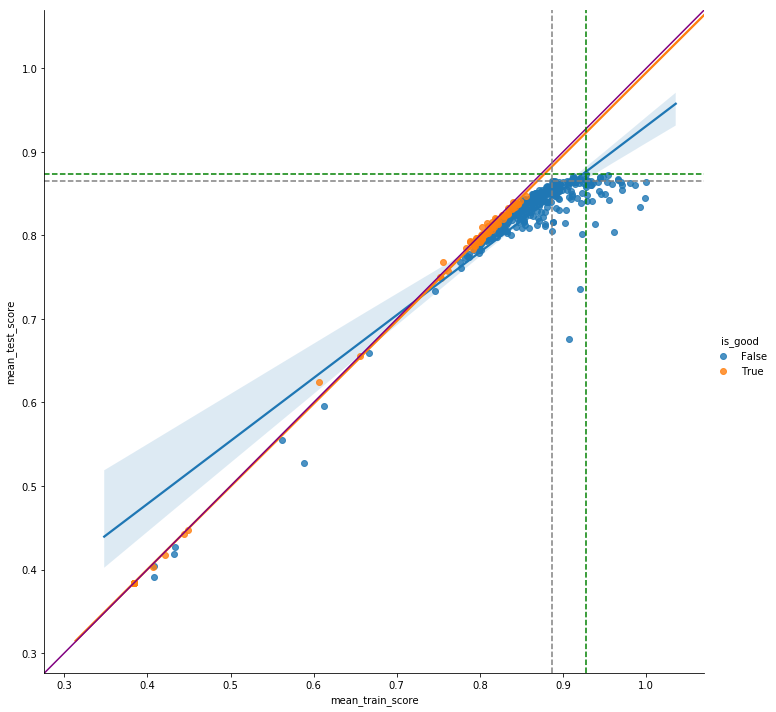

In [129]:
scip.cv_results_scatter(clf_rand_hopt)

In [127]:
n = 78
lst = [sample(ss_hopt) for _ in range(n)]
ss_rand_hopt = {k: [x[k] for x in lst] for k in ss_hopt.keys()}
# ss_rand_hopt = {k: np.unique([x[k] for x in lst]) for k in ss_hopt.keys()}


In [128]:
clf_rand_hopt = RandomizedSearchCV(model, ss_rand_hopt, scoring=scoring, cv=5, n_jobs=1, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=450,
                         )
clf_rand_hopt.fit(X, y)


Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed:  1.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
          estimator=XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9657375888930949,
       colsample_bytree=0.7415139855810371, gamma=1.7441708835176253e-07,
       learning_rate=0.001059011209818022, max_delta_step=0, max_depth=13,
       min_child_weight=3, missing=None, n_estim...69050983882,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9996079545180419),
          fit_params=None, iid=True, n_iter=450, n_jobs=1,
          param_distributions={'n_estimators': [70, 79, 77, 81, 72, 59, 75, 42, 53, 45, 83, 53, 66, 52, 77, 88, 68, 63, 32, 96, 51, 37, 61, 99, 44, 80, 47, 38, 32, 78, 41, 73, 73, 40, 72, 48, 67, 83, 64, 36, 39, 74, 48, 68, 75, 92, 83, 81, 87, 63, 54, 56, 94, 76, 72, 79, 39, 56, 54, 58, 50, 67, 48, 87, 84, 83....8299221735347918, 0.16623252411884126, 0.8820503757594302, 0.41876625818240193, 0.398540661329364]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
      

In [314]:
clf_rand = RandomizedSearchCV(model, ss_rand, scoring=scoring, cv=5, n_jobs=1, error_score=error_score, verbose=verbose, refit=refit,
                              random_state=random_state,
                              n_iter=450,
                         )
clf_rand.fit(X, y)


Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed:  1.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
          estimator=XGBClassifier(base_score=0.5, booster='gbtree',
       colsample_bylevel=0.9657375888930949,
       colsample_bytree=0.7415139855810371, gamma=1.7441708835176253e-07,
       learning_rate=0.001059011209818022, max_delta_step=0, max_depth=13,
       min_child_weight=3, missing=None, n_estim...69050983882,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9996079545180419),
          fit_params=None, iid=True, n_iter=450, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a27c88cc0>, 'learning_rate': <__main__.log_uniform object at 0x1a2897c978>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2897cda0>, 'subsample': <scipy.stats._distn_infrastructur...79cc5c0>, 'colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a296c0c88>},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
      

In [58]:
from hpsklearn import HyperoptEstimator, svc, xgboost_classification
from sklearn import svm
from hyperopt import tpe, anneal, rand, mix

# Load Data
# ...

estim = HyperoptEstimator(classifier=xgboost_classification('my'), 
                          preprocessing=[],
                          max_evals=30,
                          algo=anneal.suggest,
                          space=ss_hopt,
                         )
estim.fit(data.X_train.values, data.y_train.values)

AssertionError: 

In [125]:
scil.score(data, estim, scoring="accuracy")

hyperopt_estimator   0.84358
dtype: float64

Can't plot with only a single or no samples


In [54]:
estim.trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 0.2447552447552448,
   'loss_variance': 0.0013017613726763733,
   'status': 'ok',
   'duration': 0.6979382038116455},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'my.xgboost_colsample_bylevel': [0],
    'my.xgboost_colsample_bytree': [0],
    'my.xgboost_gamma': [0],
    'my.xgboost_learning_rate': [0],
    'my.xgboost_max_depth': [0],
    'my.xgboost_min_child_weight': [0],
    'my.xgboost_n_estimators': [0],
    'my.xgboost_reg_alpha': [0],
    'my.xgboost_reg_lambda': [0],
    'my.xgboost_rstate': [0],
    'my.xgboost_subsample': [0]},
   'vals': {'my.xgboost_colsample_bylevel': [0.9316728903270137],
    'my.xgboost_colsample_bytree': [0.9281614746425103],
    'my.xgboost_gamma': [0.06381346899872588],
    'my.xgboost_learning_rate': [0.2923035767742632],
    'my.xgboost_max_depth': [3.8820563040394367],
    'my.xgboost_min_child_weight': [20.14561204068958],
 